## 1. Imports

In [3]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

## 2. Reusable Functions

In [36]:
def get_last_n_full_calendar_years(n_years: int = 5) -> tuple[str, str]:
    """
    Return start and end dates for the last n full calendar years (YYYY-MM-DD).
    """
    end_year = datetime.today().year - 1
    start_year = end_year - (n_years - 1)

    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    return start_date, end_date

def download_daily_prices(
    ticker: str,
    start_date: str,
    end_date: str
):
    """Download daily price data for a single ticker."""
    return yf.download(
        ticker,
        start=start_date,
        end=end_date,
        interval="1d",
        auto_adjust=False
    ) 

def extract_adjusted_close(df: pd.DataFrame) -> pd.DataFrame:
    """Return date and adjusted close columns in a standard format."""
    x = df.copy()

    # Flatten yfinance MultiIndex columns if present
    if isinstance(x.columns, pd.MultiIndex):
        x.columns = x.columns.get_level_values(0)

    return (
        x[["Adj Close"]]
        .rename(columns={"Adj Close": "adj_close"})
        .reset_index()
        .rename(columns={"Date": "date"})
    )


def add_daily_returns(
    df: pd.DataFrame,
    price_col: str = "adj_close"
) -> pd.DataFrame:
    """Add daily percentage returns column."""
    df = df.copy()
    df["daily_return"] = df[price_col].pct_change()
    return df 

def filter_date_range(
    df: pd.DataFrame,
    start_date: str,
    end_date: str,
    date_col: str = "date"
) -> pd.DataFrame:
    """Filter DataFrame to a given date range."""
    return df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy() 

def compute_annual_return(
    df: pd.DataFrame,
    year: int,
    price_col: str = "adj_close"
) -> pd.DataFrame:
    """Compute full-year return for a given year."""
    return pd.DataFrame({
        "year": [year],
        "annual_return": [df[price_col].iloc[-1] / df[price_col].iloc[0] - 1]
    }) 

import pandas as pd

def compute_event_hprs(
    prices: pd.DataFrame,
    event_dates,
    horizons=(1, 5, 10, 20),
    ticker: str | None = None,
    date_col: str = "date",
    price_col: str = "adj_close",
    event_col: str = "event_date",
    direction: str = "backward",
) -> pd.DataFrame:
    """Compute pre/post holding-period returns around events at given horizons."""
    # --- prep ---
    df = prices[[date_col, price_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    df["pos"] = df.index

    cal = df[[date_col]].drop_duplicates().sort_values(date_col).reset_index(drop=True)

    events = pd.DataFrame({event_col: pd.to_datetime(event_dates)}).sort_values(event_col)

    # Map event dates -> trading dates (no look-ahead by default)
    event_map = (
        pd.merge_asof(
            events,
            cal.rename(columns={date_col: "event_trading_date"}),
            left_on=event_col,
            right_on="event_trading_date",
            direction=direction,
        )
        .merge(
            df[[date_col, "pos"]].rename(columns={date_col: "event_trading_date"}),
            on="event_trading_date",
            how="left",
        )
        .dropna(subset=["pos"])
    )
    event_map["pos"] = event_map["pos"].astype(int)

    # --- compute HPRs ---
    rows = []
    n_obs = len(df)

    for _, r in event_map.iterrows():
        t = r["pos"]
        for n in horizons:
            # PRE: t-n -> t-1 (exclude event trading day)
            s, e = t - n, t - 1
            if s >= 0 and e >= 0:
                rows.append({
                    "ticker": ticker,
                    event_col: r[event_col],
                    "event_trading_date": r["event_trading_date"],
                    "pre_post": "pre",
                    "days": int(n),
                    "start_date": df.loc[s, date_col],
                    "end_date": df.loc[e, date_col],
                    "hpr": df.loc[e, price_col] / df.loc[s, price_col] - 1,
                })

            # POST: t -> t+n (include event trading day)
            s, e = t, t + n
            if e < n_obs:
                rows.append({
                    "ticker": ticker,
                    event_col: r[event_col],
                    "event_trading_date": r["event_trading_date"],
                    "pre_post": "post",
                    "days": int(n),
                    "start_date": df.loc[s, date_col],
                    "end_date": df.loc[e, date_col],
                    "hpr": df.loc[e, price_col] / df.loc[s, price_col] - 1,
                })

    return (
        pd.DataFrame(rows)
        .sort_values([event_col, "pre_post", "days"])
        .reset_index(drop=True)
    )

def plot_mean_event_hprs(
    hpr_table: pd.DataFrame,
    title: str,
    hpr_col: str = "hpr",
    horizon_col: str = "days",
    group_col: str = "pre_post",
):
    """Plot mean pre/post event HPRs by holding period."""
    plot_df = (
        hpr_table
        .groupby([group_col, horizon_col])[hpr_col]
        .mean()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(8, 5))

    for label, grp in plot_df.groupby(group_col):
        offset = -0.2 if label == "pre" else 0.2
        ax.bar(
            grp[horizon_col] + offset,
            grp[hpr_col],
            width=0.35,
            label=label.capitalize()
        )

    ax.set_xlabel("Holding period (trading days)")
    ax.set_ylabel("Mean Holding Period Return")
    ax.set_title(title)
    ax.legend()

    return ax 

def plot_event_hpr_overlay(
    hpr_table: pd.DataFrame,
    horizons=(1, 5, 10, 20),
    pre_post: str = "post",
    event_col: str = "earnings_date",
    horizon_col: str = "days",
    value_col: str = "hpr",
    title: str = "Event HPR Overlay",
):
    """Plot HPR curves per event across horizons (overlay)."""
    df = hpr_table.copy()
    df[event_col] = pd.to_datetime(df[event_col])
    df[horizon_col] = df[horizon_col].astype(int)

    df = df[df["pre_post"] == pre_post]

    pivot = (
        df.pivot(index=event_col, columns=horizon_col, values=value_col)
        .sort_index()
    )

    horizons = [int(h) for h in horizons]
    pivot = pivot.reindex(columns=horizons)

    fig, ax = plt.subplots(figsize=(9, 5))

    for event_dt, row in pivot.iterrows():
        ax.plot(horizons, row.values, marker="o", label=event_dt.strftime("%Y-%m-%d"))

    ax.axhline(0, linewidth=1)
    ax.set_xlabel("Holding period (trading days)")
    ax.set_ylabel("Holding Period Return (HPR)")
    ax.set_title(title)
    ax.legend(title="Event date", frameon=False)

    return ax 

def compute_event_hprs_with_benchmarks(
    asset: pd.DataFrame,
    benchmarks: dict[str, pd.DataFrame],
    event_dates,
    horizons=(1, 5, 10, 20),
    asset_name: str = "asset",
    date_col: str = "date",
    price_col: str = "adj_close",
    event_col: str = "event_date",
    direction: str = "backward",
) -> pd.DataFrame:
    """Compute pre/post HPRs for an asset and benchmark HPRs on the same windows."""
    def _prepare_prices(df: pd.DataFrame) -> pd.DataFrame:
        x = df.copy()
        if isinstance(x.columns, pd.MultiIndex):
            x.columns = x.columns.get_level_values(0)
        if date_col not in x.columns and "Date" in x.columns:
            x = x.rename(columns={"Date": date_col})
        x[date_col] = pd.to_datetime(x[date_col])
        return x.sort_values(date_col).reset_index(drop=True)

    def _px_asof(df_prices: pd.DataFrame, target_date) -> float:
        tmp = pd.merge_asof(
            pd.DataFrame({date_col: [pd.to_datetime(target_date)]}).sort_values(date_col),
            df_prices[[date_col, price_col]].sort_values(date_col),
            on=date_col,
            direction="backward",
        )
        return float(tmp.loc[0, price_col])

    # --- prep ---
    asset_df = _prepare_prices(asset)
    bench_dfs = {k: _prepare_prices(v) for k, v in benchmarks.items()}

    # Trading calendar from asset (drives windows)
    cal = (
        asset_df[[date_col]]
        .drop_duplicates()
        .sort_values(date_col)
        .reset_index(drop=True)
    )

    events = pd.DataFrame({event_col: pd.to_datetime(event_dates)}).sort_values(event_col)

    event_map = pd.merge_asof(
        events,
        cal.rename(columns={date_col: "event_trading_date"}).sort_values("event_trading_date"),
        left_on=event_col,
        right_on="event_trading_date",
        direction=direction,
    )

    asset_df = asset_df.drop(columns=["pos"], errors="ignore")
    asset_df["pos"] = asset_df.index

    event_map = (
        event_map.merge(
            asset_df[[date_col, "pos"]].rename(columns={date_col: "event_trading_date"}),
            on="event_trading_date",
            how="left",
        )
        .dropna(subset=["pos"])
    )
    event_map["pos"] = event_map["pos"].astype(int)

    horizons = [int(h) for h in horizons]
    rows = []
    n_obs = len(asset_df)

    # --- compute ---
    for _, r in event_map.iterrows():
        t = int(r["pos"])
        event_dt = r[event_col]
        trading_dt = r["event_trading_date"]

        for n in horizons:
            # PRE: t-n -> t-1
            s, e = t - n, t - 1
            if s >= 0 and e >= 0:
                s_dt, e_dt = asset_df.loc[s, date_col], asset_df.loc[e, date_col]
                asset_hpr = asset_df.loc[e, price_col] / asset_df.loc[s, price_col] - 1

                out = {
                    "asset": asset_name,
                    event_col: event_dt,
                    "event_trading_date": trading_dt,
                    "pre_post": "pre",
                    "days": n,
                    "window_label": f"pre_{n}d",
                    "start_date": s_dt,
                    "end_date": e_dt,
                    f"{asset_name}_hpr": asset_hpr,
                }
                for name, bdf in bench_dfs.items():
                    b_s = _px_asof(bdf, s_dt)
                    b_e = _px_asof(bdf, e_dt)
                    out[f"{name}_hpr"] = b_e / b_s - 1

                rows.append(out)

            # POST: t -> t+n
            s, e = t, t + n
            if e < n_obs:
                s_dt, e_dt = asset_df.loc[s, date_col], asset_df.loc[e, date_col]
                asset_hpr = asset_df.loc[e, price_col] / asset_df.loc[s, price_col] - 1

                out = {
                    "asset": asset_name,
                    event_col: event_dt,
                    "event_trading_date": trading_dt,
                    "pre_post": "post",
                    "days": n,
                    "window_label": f"post_{n}d",
                    "start_date": s_dt,
                    "end_date": e_dt,
                    f"{asset_name}_hpr": asset_hpr,
                }
                for name, bdf in bench_dfs.items():
                    b_s = _px_asof(bdf, s_dt)
                    b_e = _px_asof(bdf, e_dt)
                    out[f"{name}_hpr"] = b_e / b_s - 1

                rows.append(out)

    return (
        pd.DataFrame(rows)
        .sort_values([event_col, "pre_post", "days"])
        .reset_index(drop=True)
    )

def plot_mean_hpr_comparison(
    hpr_table: pd.DataFrame,
    series_cols: list[str],
    title: str,
    phase_col: str = "pre_post",
    horizon_col: str = "days",
    figsize: tuple[int, int] = (14, 5),
):
    """Plot mean HPR by horizon for pre vs post, comparing multiple series."""
    plot_df = (
        hpr_table
        .groupby([phase_col, horizon_col])
        .agg(**{c: (c, "mean") for c in series_cols})
        .reset_index()
    )

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    for ax, phase in zip(axes, ["pre", "post"]):
        subset = plot_df[plot_df[phase_col] == phase]
        for c in series_cols:
            ax.plot(subset[horizon_col], subset[c], marker="o", label=c.replace("_hpr", "").upper())

        ax.set_title(f"{phase.capitalize()}-Event HPR Comparison")
        ax.set_xlabel("Holding period (trading days)")
        ax.grid(True)

    axes[0].set_ylabel("Mean Holding Period Return (decimal)")
    axes[1].legend()

    fig.suptitle(title)
    fig.tight_layout()

    return axes 

def plot_post_event_overlay_by_series(
    hpr_table: pd.DataFrame,
    series_specs: list[tuple[str, str]],
    horizons=(1, 5, 10, 20),
    title: str = "Post-Event HPR Overlay",
    event_col: str = "earnings_date",
    phase_col: str = "pre_post",
    phase: str = "post",
    horizon_col: str = "days",
    figsize: tuple[int, int] = (16, 5),
):
    """Overlay event-level post (or pre) HPR curves across horizons for multiple series."""
    df = hpr_table.copy()
    df[event_col] = pd.to_datetime(df[event_col])
    df[horizon_col] = df[horizon_col].astype(int)

    df = df[df[phase_col] == phase].copy()
    horizons = [int(h) for h in horizons]

    fig, axes = plt.subplots(1, len(series_specs), figsize=figsize, sharey=True)
    if len(series_specs) == 1:
        axes = [axes]

    for ax, (col, series_title) in zip(axes, series_specs):
        piv = (
            df.pivot(index=event_col, columns=horizon_col, values=col)
            .sort_index()
            .reindex(columns=horizons)
        )

        for event_dt, row in piv.iterrows():
            ax.plot(horizons, row.values, marker="o", label=event_dt.strftime("%Y-%m-%d"))

        ax.axhline(0, linewidth=1)
        ax.set_title(series_title)
        ax.set_xlabel("Holding period (trading days)")
        ax.grid(True)

    axes[0].set_ylabel("Holding Period Return (decimal)")
    axes[-1].legend(title="Event date", frameon=False)

    fig.suptitle(title)
    fig.tight_layout()

    return axes 

def build_returns_event_map_and_car(
    price_data: dict[str, pd.DataFrame],
    asset_key: str,
    benchmark_keys: list[str],
    event_dates,
    event_window: int = 5,
    date_col: str = "date",
    price_col: str = "adj_close",
    direction: str = "backward",
    event_col: str = "event_date",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Build aligned returns, event map, event-window abnormal-return panel, and CAR table.
    """
    def _clean(df: pd.DataFrame) -> pd.DataFrame:
        x = df[[date_col, price_col]].copy()
        x[date_col] = pd.to_datetime(x[date_col], errors="coerce").dt.normalize()
        x[price_col] = pd.to_numeric(x[price_col], errors="coerce")
        return x.dropna(subset=[date_col, price_col]).sort_values(date_col).reset_index(drop=True)

    # ---- 1) Clean + returns (per series) ----
    cleaned = {}
    for k, df in price_data.items():
        x = _clean(df)
        x[f"ret_{k}"] = x[price_col].pct_change()
        cleaned[k] = x

    # ---- 2) Merge returns (inner-join on dates) ----
    returns_df = cleaned[asset_key][[date_col, f"ret_{asset_key}"]].copy()
    for k in cleaned:
        if k != asset_key:
            returns_df = returns_df.merge(
                cleaned[k][[date_col, f"ret_{k}"]],
                on=date_col,
                how="inner",
            )
    returns_df = returns_df.sort_values(date_col).reset_index(drop=True)

    # ---- 3) Abnormal returns: asset vs each benchmark ----
    for b in benchmark_keys:
        returns_df[f"ar_{asset_key}_vs_{b}"] = returns_df[f"ret_{asset_key}"] - returns_df[f"ret_{b}"]

    # ---- 4) Map events -> trading day + position ----
    cal = returns_df[[date_col]].drop_duplicates().sort_values(date_col).reset_index(drop=True)

    event_map = pd.merge_asof(
        pd.DataFrame({event_col: pd.to_datetime(event_dates)}).sort_values(event_col),
        cal.rename(columns={date_col: "event_trading_date"}),
        left_on=event_col,
        right_on="event_trading_date",
        direction=direction,
    )

    idx_map = returns_df.reset_index().rename(columns={"index": "pos"})[[date_col, "pos"]]
    event_map = (
        event_map.merge(
            idx_map.rename(columns={date_col: "event_trading_date"}),
            on="event_trading_date",
            how="left",
        )
        .dropna(subset=["pos"])
    )
    event_map["pos"] = event_map["pos"].astype(int)

    # ---- 5) Build event-window panel (event_day = -w..+w) ----
    event_windows = []
    for _, r in event_map.iterrows():
        t = int(r["pos"])
        if t - event_window < 0 or t + event_window >= len(returns_df):
            continue

        w = returns_df.iloc[t - event_window : t + event_window + 1].copy()
        w[event_col] = r[event_col]
        w["event_day"] = np.arange(-event_window, event_window + 1)
        event_windows.append(w)

    event_returns = (
        pd.concat(event_windows, ignore_index=True)
        if event_windows else
        pd.DataFrame(columns=list(returns_df.columns) + [event_col, "event_day"])
    )

    # ---- 6) CAR table (two standard windows: [-w,+w] and [0,+w]) ----
    car_rows = []
    for ev, g in event_returns.groupby(event_col):
        row = {event_col: ev}
        for b in benchmark_keys:
            ar_col = f"ar_{asset_key}_vs_{b}"
            row[f"CAR_-{event_window}_+{event_window}_vs_{b}"] = g.loc[
                (g["event_day"] >= -event_window) & (g["event_day"] <= event_window),
                ar_col
            ].sum(min_count=1)
            row[f"CAR_0_+{event_window}_vs_{b}"] = g.loc[
                (g["event_day"] >= 0) & (g["event_day"] <= event_window),
                ar_col
            ].sum(min_count=1)
        car_rows.append(row)

    car_table = pd.DataFrame(car_rows).sort_values(event_col).reset_index(drop=True)

    return returns_df, event_map, event_returns, car_table
import matplotlib.pyplot as plt
import pandas as pd

def plot_mean_car(
    event_returns: pd.DataFrame,
    ar_cols: list[str],
    event_day_col: str = "event_day",
    title: str = "Mean Cumulative Abnormal Return",
    figsize: tuple[int, int] = (9, 5),
):
    """Plot mean cumulative abnormal returns across events."""
    mean_car = (
        event_returns
        .sort_values(event_day_col)
        .groupby(event_day_col)[ar_cols]
        .mean()
        .cumsum()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=figsize)

    for col in ar_cols:
        ax.plot(
            mean_car[event_day_col],
            mean_car[col],
            marker="o",
            label=col.replace("_", " ").upper()
        )

    ax.axvline(0, linestyle="--")
    ax.set_xlabel("Event day (0 = event)")
    ax.set_ylabel("Cumulative Abnormal Return (CAR)")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    return ax
def plot_event_level_car_overlay(
    event_returns: pd.DataFrame,
    ar_cols: list[str],
    event_col: str = "event_date",
    event_day_col: str = "event_day",
    titles: list[str] | None = None,
    suptitle: str = "Event-Level CAR Overlay",
    figsize: tuple[int, int] = (14, 5),
):
    """
    Plot event-level cumulative abnormal return (CAR) paths over event days,
    overlaid by event date for one or more abnormal-return series.
    """
    df = event_returns.copy()
    df[event_col] = pd.to_datetime(df[event_col])
    df[event_day_col] = df[event_day_col].astype(int)

    # Compute CAR paths per event
    for col in ar_cols:
        df[f"car_{col}"] = df.sort_values([event_col, event_day_col]) \
                              .groupby(event_col)[col] \
                              .cumsum()

    fig, axes = plt.subplots(1, len(ar_cols), figsize=figsize, sharey=True)
    if len(ar_cols) == 1:
        axes = [axes]

    if titles is None:
        titles = [col.replace("_", " ").upper() for col in ar_cols]

    for ax, col, title in zip(axes, ar_cols, titles):
        car_col = f"car_{col}"
        for ev, grp in df.groupby(event_col):
            ax.plot(
                grp[event_day_col],
                grp[car_col],
                marker="o",
                label=ev.strftime("%Y-%m-%d")
            )

        ax.axvline(0, linestyle="--")
        ax.set_xlabel("Event day (0 = event)")
        ax.set_title(title)
        ax.grid(True)

    axes[0].set_ylabel("Cumulative Abnormal Return (CAR)")
    axes[-1].legend(title="Event date", frameon=False)

    fig.suptitle(suptitle)
    fig.tight_layout()

    return axes 

def build_headline_earnings_features(
    earnings_dates,
    revenue,
    operating_income,
    net_income,
    eps_actual,
    eps_consensus,
    event_col: str = "earnings_date",
    revenue_col: str = "revenue",
    op_income_col: str = "operating_income",
    net_income_col: str = "net_income",
    eps_actual_col: str = "eps_actual",
    eps_consensus_col: str = "eps_consensus",
    ebit_col: str = "ebit",
    ebit_source_col: str = "operating_income",
    qoq_col: str = "revenue_qoq",
    yoy_col: str = "revenue_yoy",
    compute_yoy: bool = False,
    surprise_col: str = "eps_surprise",
    result_col: str = "eps_result",
    labels: tuple[str, str, str] = ("Beat", "Meet", "Miss"),
) -> pd.DataFrame:
    """Build headline earnings table + EBIT, revenue growth, EPS surprise, and result label."""
    df = pd.DataFrame({
        event_col: pd.to_datetime(earnings_dates),
        revenue_col: revenue,
        op_income_col: operating_income,
        net_income_col: net_income,
        eps_actual_col: eps_actual,
        eps_consensus_col: eps_consensus,
    }).sort_values(event_col).reset_index(drop=True)

    # EBIT proxy
    df[ebit_col] = df[ebit_source_col]

    # Revenue growth
    df[qoq_col] = df[revenue_col].pct_change()
    df[yoy_col] = df[revenue_col].pct_change(4) if compute_yoy else np.nan

    # EPS surprise + result
    df[surprise_col] = df[eps_actual_col] - df[eps_consensus_col]
    beat, meet, miss = labels
    df[result_col] = df[surprise_col].apply(lambda v: beat if v > 0 else (miss if v < 0 else meet))

    return df

def plot_fundamental_timeseries(
    df: pd.DataFrame,
    date_col: str,
    value_col: str,
    title: str,
    ylabel: str,
    figsize: tuple[int, int] = (8, 4),
    marker: str = "o",
):
    """Plot a time-series fundamental metric over event dates."""
    x = df.copy().sort_values(date_col)

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        x[date_col],
        x[value_col],
        marker=marker
    )

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    ax.grid(True)

    return ax 

def plot_fundamental_comparison(
    df: pd.DataFrame,
    date_col: str,
    value_cols: list[str],
    labels: list[str] | None = None,
    title: str = "Fundamental Comparison",
    ylabel: str = "",
    figsize: tuple[int, int] = (8, 4),
    marker: str = "o",
):
    """Plot multiple fundamental series over time on a single axis."""
    x = df.copy().sort_values(date_col)

    fig, ax = plt.subplots(figsize=figsize)

    if labels is None:
        labels = value_cols

    for col, lbl in zip(value_cols, labels):
        ax.plot(
            x[date_col],
            x[col],
            marker=marker,
            label=lbl
        )

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

    return ax 


def plot_actual_vs_consensus(
    df: pd.DataFrame,
    date_col: str,
    actual_col: str,
    consensus_col: str,
    title: str = "Actual vs Consensus",
    ylabel: str = "",
    figsize: tuple[int, int] = (9, 5),
    marker: str = "o",
):
    """Plot actual vs consensus values over time."""
    x = df.copy().sort_values(date_col)

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        x[date_col],
        x[actual_col],
        marker=marker,
        label="Actual"
    )

    ax.plot(
        x[date_col],
        x[consensus_col],
        marker=marker,
        linestyle="--",
        label="Consensus"
    )

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

    return ax 

def plot_surprise_bars(
    df: pd.DataFrame,
    date_col: str,
    actual_col: str,
    consensus_col: str,
    surprise_col: str = "surprise",
    title: str = "Surprise by Event",
    ylabel: str = "Surprise (Actual − Consensus)",
    figsize: tuple[int, int] = (9, 5),
):
    """Plot bar chart of surprises, coloured by sign, with value labels."""
    xdf = df.copy().sort_values(date_col).reset_index(drop=True)

    # Defensive: compute surprise if missing
    if surprise_col not in xdf.columns:
        xdf[surprise_col] = xdf[actual_col] - xdf[consensus_col]

    # Categorical x positions
    x = np.arange(len(xdf))
    labels = xdf[date_col].dt.strftime("%Y-%m-%d")

    # Colour by sign
    colors = xdf[surprise_col].apply(
        lambda v: "green" if v > 0 else ("red" if v < 0 else "grey")
    )

    fig, ax = plt.subplots(figsize=figsize)

    bars = ax.bar(x, xdf[surprise_col], color=colors, width=0.6)

    ax.axhline(0, linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Event Date")
    ax.set_ylabel(ylabel)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)

    ax.grid(True, axis="y")

    # Value labels
    for rect, val in zip(bars, xdf[surprise_col]):
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            val,
            f"{val:+.2f}",
            ha="center",
            va="bottom" if val >= 0 else "top",
        )

    return ax 

def build_quarterly_profitability_and_roce(
    quarterly_data: list[tuple],
    columns: list[str],
    date_col: str = "period_end",
    revenue_col: str = "revenue_m",
    gross_margin_pct_col: str = "gross_margin_pct",
    operating_income_col: str = "operating_income_m",
    total_assets_col: str = "total_assets_m",
    current_liabilities_col: str = "current_liabilities_m",
) -> pd.DataFrame:
    """
    Build quarterly profitability metrics (gross margin, operating margin)
    and ROCE from manually supplied GAAP inputs.

    Assumes consistent units (e.g. $m) across inputs.
    """

    df = pd.DataFrame(quarterly_data, columns=columns).copy()

    # Parse date
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Core ratios
    df["gross_margin"] = df[gross_margin_pct_col] / 100.0
    df["operating_margin"] = df[operating_income_col] / df[revenue_col]

    # ROCE
    capital_employed = df[total_assets_col] - df[current_liabilities_col]
    df["roce"] = (df[operating_income_col] / capital_employed).replace(
        [np.inf, -np.inf], np.nan
    )

    return (
        df[[date_col, "gross_margin", "operating_margin", "roce"]]
        .sort_values(date_col)
        .reset_index(drop=True)
    )


def build_profitability_metrics_manual(
    quarterly_metrics: pd.DataFrame,
    event_dates,
    earnings_col: str = "earnings_date",
    direction: str = "backward",
) -> pd.DataFrame:
    """
    Align manually-provided quarterly profitability metrics to event dates (no look-ahead).
    Expects quarterly_metrics columns:
      - period_end (date)
      - gross_margin (decimal, e.g. 0.751)
      - operating_margin (decimal, e.g. 0.621)
    """
    q = quarterly_metrics.copy()
    q["period_end"] = pd.to_datetime(q["period_end"])
    q = q.sort_values("period_end").reset_index(drop=True)

    # QoQ deltas (margin points, in decimal units)
    q["delta_gross_margin_qoq"] = q["gross_margin"].diff(1)
    q["delta_operating_margin_qoq"] = q["operating_margin"].diff(1)

    events = pd.DataFrame({earnings_col: pd.to_datetime(event_dates)}).sort_values(earnings_col)

    aligned = pd.merge_asof(
        events,
        q,
        left_on=earnings_col,
        right_on="period_end",
        direction=direction,
    )

    return aligned[[earnings_col, "period_end", "gross_margin", "operating_margin",
                    "delta_gross_margin_qoq", "delta_operating_margin_qoq"]]


def plot_margins_over_time(
    df: pd.DataFrame,
    date_col: str,
    margin_cols: list[str],
    labels: list[str] | None = None,
    title: str = "Quarterly Margins",
    xlabel: str = "Period end",
    ylabel: str = "Margin",
    figsize: tuple[int, int] = (8, 4),
    rotate_xticks: int = 45,
    as_percent: bool = True,
    marker: str = "o",
) -> plt.Axes:
    """Plot one or more margin series over time."""
    x = df[[date_col, *margin_cols]].copy()
    x[date_col] = pd.to_datetime(x[date_col], errors="coerce")
    x = x.dropna(subset=[date_col]).sort_values(date_col)

    if labels is None:
        labels = margin_cols
    if len(labels) != len(margin_cols):
        raise ValueError("labels must match length of margin_cols.")

    fig, ax = plt.subplots(figsize=figsize)
    for col, lbl in zip(margin_cols, labels):
        ax.plot(x[date_col], x[col], marker=marker, label=lbl)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis="x", rotation=rotate_xticks)
    if as_percent:
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    fig.tight_layout()
    return ax

def plot_metric_change_over_time(
    df: pd.DataFrame,
    date_col: str,
    value_col: str,
    title: str = "Metric change over time",
    xlabel: str = "Date",
    ylabel: str = "Change",
    label: str | None = None,
    figsize: tuple[int, int] = (8, 4),
    marker: str = "o",
    rotate_xticks: int = 45,
    show_zero_line: bool = True,
    as_percent: bool = True,
) -> plt.Axes:
    """Plot a change series over time with optional zero reference line."""
    x = df[[date_col, value_col]].copy()
    x[date_col] = pd.to_datetime(x[date_col], errors="coerce")
    x = x.dropna(subset=[date_col]).sort_values(date_col)

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        x[date_col],
        x[value_col],
        marker=marker,
        label=label or value_col,
    )

    if show_zero_line:
        ax.axhline(0, linestyle="--", linewidth=1)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis="x", rotation=rotate_xticks)

    if as_percent:
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    fig.tight_layout()
    return ax


def plot_ratio_over_time(
    df: pd.DataFrame,
    date_col: str,
    value_col: str,
    title: str = "Ratio over time",
    xlabel: str = "Date",
    ylabel: str = "Ratio",
    figsize: tuple[int, int] = (10, 4),
    marker: str = "o",
    linewidth: float = 1.5,
    show_zero_line: bool = True,
    as_percent: bool = True,
) -> plt.Axes:
    """Plot a financial ratio over time with clean date formatting."""
    x = df[[date_col, value_col]].copy()
    x[date_col] = pd.to_datetime(x[date_col], errors="coerce")
    x[value_col] = pd.to_numeric(x[value_col], errors="coerce")
    x = x.dropna(subset=[date_col]).sort_values(date_col)

    if x.empty:
        raise ValueError(f"No rows to plot after parsing/filtering ({date_col}).")

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        x[date_col],
        x[value_col],
        marker=marker,
        linewidth=linewidth,
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if show_zero_line:
        ax.axhline(0, linewidth=1, linestyle="--")

    ax.grid(True, alpha=0.4)

    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    # If only one point, tighten x-axis around it (prevents multi-year span)
    if len(x) == 1:
        d = x[date_col].iloc[0]
        ax.set_xlim(d - pd.Timedelta(days=90), d + pd.Timedelta(days=90))

    if as_percent:
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    fig.tight_layout()
    return ax

def build_valuation_snapshot_from_yahoo(
    ticker: str,
    event_dates=None,
    event_col: str = "event_date",
    metrics: dict[str, str] | None = None,
) -> pd.DataFrame:
    """
    Pull current Yahoo Finance valuation multiples and label them as a snapshot
    taken after the most recent event date in `event_dates` (or most recent Yahoo
    earnings date if `event_dates` is None).
    """
    tkr = yf.Ticker(ticker)
    info = tkr.info or {}

    if metrics is None:
        metrics = {
            "Forward P/E": "forwardPE",
            "EV / EBITDA": "enterpriseToEbitda",
        }

    # Determine the "most recent earnings date" label (no historical valuation from Yahoo info)
    asof_event = None
    if event_dates is not None:
        s = pd.to_datetime(pd.Series(event_dates), errors="coerce").dropna()
        if not s.empty:
            asof_event = s.max()
    else:
        # Fallback: try Yahoo earnings dates table
        try:
            ed = tkr.get_earnings_dates(limit=8)
            if ed is not None and not ed.empty:
                # yfinance commonly uses the index as the earnings datetime
                asof_event = pd.to_datetime(ed.index, errors="coerce").max()
        except Exception:
            asof_event = None

    rows = []
    for label, key in metrics.items():
        rows.append({
            "ticker": ticker,
            event_col: asof_event,
            "metric": label,
            "value": info.get(key, None),
            "source": "yahoo_finance_current_snapshot",
        })

    return pd.DataFrame(rows)

## 3. EDA

In [5]:
start_date, end_date = get_last_n_full_calendar_years(n_years=6)

In [6]:
nvda = download_daily_prices("NVDA", start_date, end_date)
spy  = download_daily_prices("SPY",  start_date, end_date)
qqq  = download_daily_prices("QQQ",  start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
nvda_adj = extract_adjusted_close(nvda)
spy_adj  = extract_adjusted_close(spy)
qqq_adj  = extract_adjusted_close(qqq)

In [8]:
nvda_adj = add_daily_returns(nvda_adj)
spy_adj  = add_daily_returns(spy_adj)
qqq_adj  = add_daily_returns(qqq_adj)

In [9]:
nvda_2025 = filter_date_range(
    nvda_adj,
    start_date="2025-01-01",
    end_date="2025-12-31"
)

In [10]:
annual_returns_2025 = compute_annual_return(nvda_2025, year=2025) 
annual_returns_2025

,year,annual_return
0,2025,0.35631


In [11]:
earnings_dates_2025 = ["2025-02-26", "2025-05-28", "2025-08-27", "2025-11-19"]
earnings_dates_2024 = ["2024-02-21", "2024-05-22", "2024-08-28", "2024-11-20"]
earnings_dates_2023 = ["2023-02-22", "2023-05-24", "2023-08-23", "2023-11-21"]
horizons = [1, 5, 10, 20]

hpr_table_2025 = compute_event_hprs(
    prices=nvda_adj,
    event_dates=earnings_dates_2025,
    horizons=horizons,
    ticker="NVDA",
    date_col="date",
    price_col="adj_close",
    event_col="earnings_date",
)

hpr_table_2024 = compute_event_hprs(
    prices=nvda_adj,
    event_dates=earnings_dates_2024,
    horizons=horizons,
    ticker="NVDA",
    date_col="date",
    price_col="adj_close",
    event_col="earnings_date",
)

hpr_table_2023 = compute_event_hprs(
    prices=nvda_adj,
    event_dates=earnings_dates_2023,
    horizons=horizons,
    ticker="NVDA",
    date_col="date",
    price_col="adj_close",
    event_col="earnings_date",
)

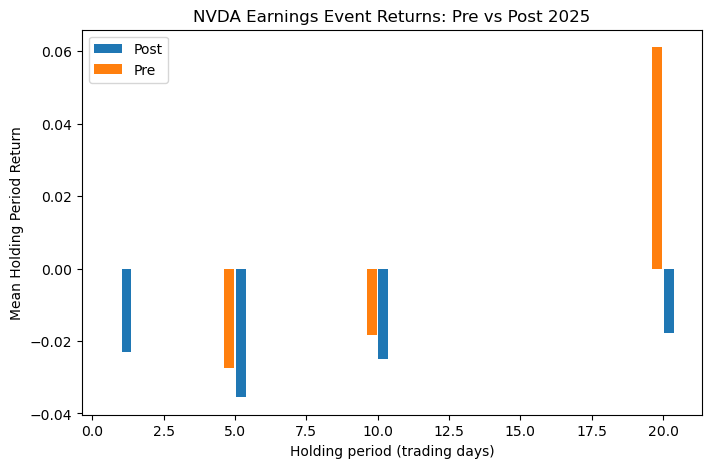

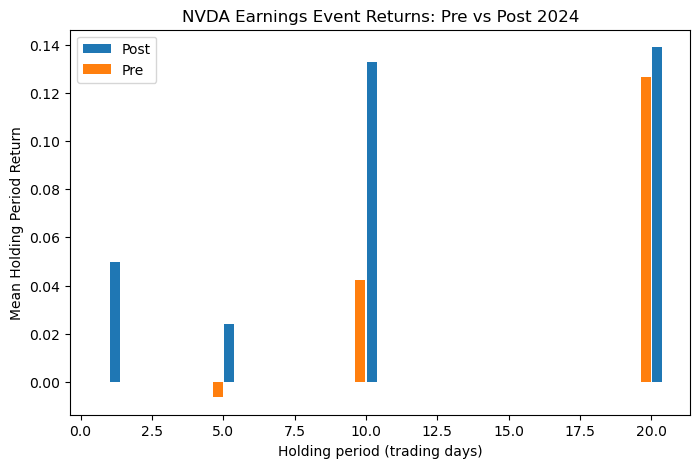

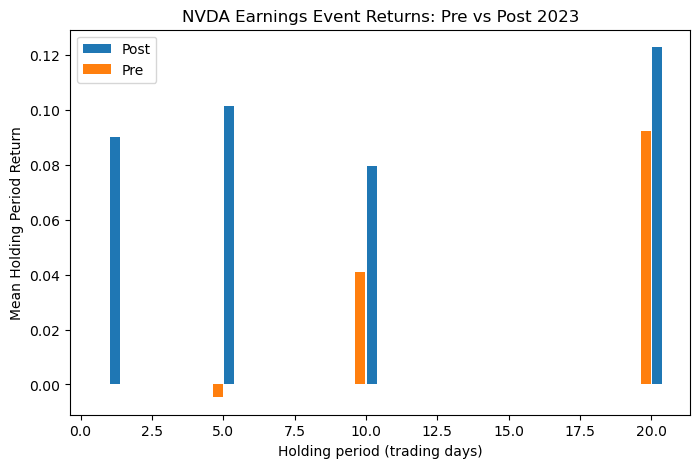

In [12]:
plot_mean_event_hprs(
    hpr_table_2025,
    title="NVDA Earnings Event Returns: Pre vs Post 2025"
)
plt.show()

plot_mean_event_hprs(
    hpr_table_2024,
    title="NVDA Earnings Event Returns: Pre vs Post 2024"
)
plt.show()

plot_mean_event_hprs(
    hpr_table_2023,
    title="NVDA Earnings Event Returns: Pre vs Post 2023"
)
plt.show()

## Mean Earnings Event Returns (Pre vs Post): Context

### What this shows
Mean **Holding Period Returns (HPRs)** for NVIDIA around earnings announcements, split into:
- **Pre-earnings vs post-earnings**
- **1, 5, 10, and 20 trading-day horizons**
- **Years: 2023, 2024, 2025**

Returns use **Adjusted Close prices** and are averaged across all earnings events within each year.

---

### Purpose
This is a **context-setting diagnostic**, not a strategy signal.  
It validates the earnings-event framework and motivates deeper event-level analysis.

---

### Key observations
- **Post-earnings mean returns generally exceed pre-earnings returns**, especially at **10–20 day horizons**
- **Significant variation across years**, with stronger drift in 2023–2024 and mixed outcomes in 2025
- **Annual means mask large quarter-level dispersion**

---

### Interpretation
Annual averages are **descriptive only**:
- Do not explain quarter-specific behaviour
- Do not generate tradable signals
- Hide expectation-reset dynamics

---

### Why this matters
This step:
- Confirms correct earnings alignment and HPR logic
- Shows earnings information is incorporated **after** the event
- Justifies moving to **quarter-level CAR, fundamentals, and benchmark-adjusted analysis**

---

### Takeaway
**Actionable insights for NVIDIA emerge at the individual earnings-event level, not from annual mean returns.**


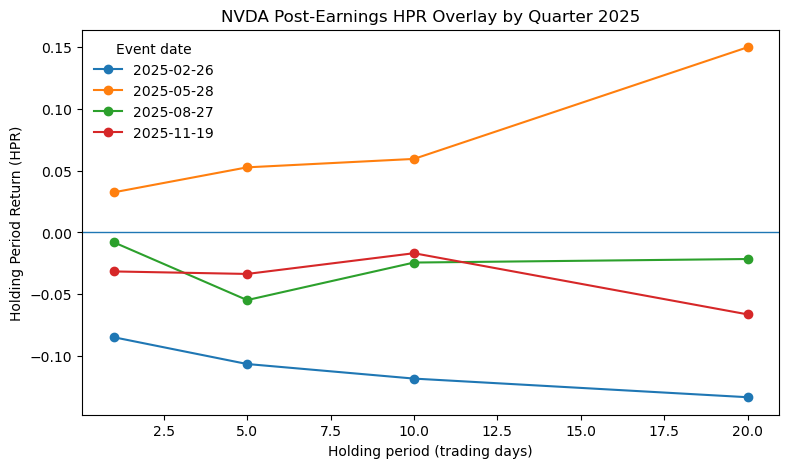

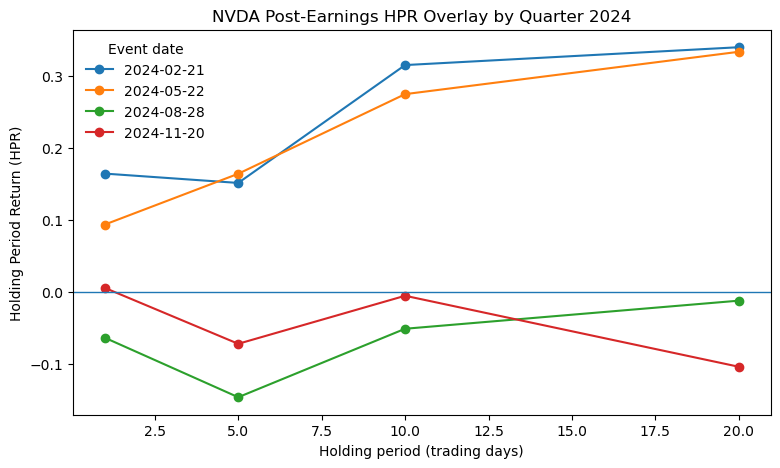

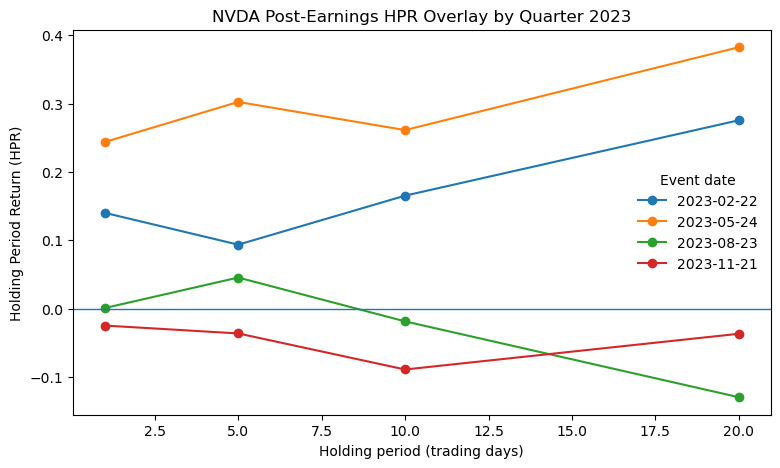

In [13]:
plot_event_hpr_overlay(
    hpr_table_2025,
    horizons=[1, 5, 10, 20],
    pre_post="post",
    event_col="earnings_date",  # ✅ column in the table
    title="NVDA Post-Earnings HPR Overlay by Quarter 2025",
)
plt.show()

plot_event_hpr_overlay(
    hpr_table_2024,
    horizons=[1, 5, 10, 20],
    pre_post="post",
    event_col="earnings_date",
    title="NVDA Post-Earnings HPR Overlay by Quarter 2024",
)
plt.show()

plot_event_hpr_overlay(
    hpr_table_2023,
    horizons=[1, 5, 10, 20],
    pre_post="post",
    event_col="earnings_date",
    title="NVDA Post-Earnings HPR Overlay by Quarter 2023",
)
plt.show()


## Post-Earnings HPR Overlay by Quarter (1/5/10/20 trading days)

### What this shows
For each year (2023, 2024, 2025), this plot overlays **post-earnings Holding Period Returns (HPRs)** by **individual earnings event date** across fixed horizons:
- **+1, +5, +10, +20 trading days**
- **Post-earnings only** (returns measured from the earnings date forward)
- Each line = one quarter’s earnings event (e.g., Feb/May/Aug/Nov)

This moves beyond annual averages and reveals **quarter-level dispersion**.

---

### Key observations (by year)

#### 2025 (high dispersion; mixed outcomes)
- **May 2025** is the standout: **positive across all horizons**, with the **largest gains at +20 days** (strong post-earnings drift).
- **Feb 2025** is consistently negative and worsens with horizon (persistent drawdown post-event).
- **Aug 2025** is near-flat to mildly negative across horizons (no strong drift).
- **Nov 2025** is modestly negative and deteriorates by +20 days.

**Implication:** 2025 outcomes are **not uniform**; the “edge” appears concentrated in specific quarters (especially May), supporting a **selective, event-conditional approach** rather than a blanket “buy every earnings” rule.

---

#### 2024 (very strong upside in Feb/May; two weak quarters)
- **Feb and May 2024** show **large positive post-earnings returns** that generally **increase with horizon** (strong drift into +10/+20 days).
- **Aug and Nov 2024** are negative/weak (downside quarters), again highlighting dispersion.

**Implication:** Even in a strong year, earnings reactions split into **high-upside vs low/negative quarters**, reinforcing the need for fundamentals/expectation context to discriminate between events.

---

#### 2023 (positive in Feb/May; weak/negative in Aug/Nov)
- **May 2023** shows strong positive post-earnings returns across horizons (clear drift).
- **Feb 2023** is also positive and improves with longer horizons.
- **Aug 2023** turns meaningfully negative by +20 days.
- **Nov 2023** is mildly negative across horizons.

**Implication:** The recurring pattern is that **some quarters deliver pronounced post-earnings drift**, while others do not—consistent with an event-driven framework where **signal quality varies by quarter**.

---

### Interpretation
These overlays demonstrate that NVIDIA’s earnings behaviour is driven by **event-level dynamics**, not stable annual averages:
- Post-earnings returns can be **strongly positive** or **meaningfully negative** depending on the quarter.
- The largest opportunities (when they occur) tend to **compound over 10–20 trading days**, aligning with your fixed-horizon strategy design.

---

### Why this output matters for the strategy
This plot provides the empirical basis for two core strategy principles:
1. **Selectivity:** avoid a naïve “trade every earnings” approach (dispersion is large).
2. **Horizon choice:** when post-earnings drift exists, it often **builds over +10 to +20 days**, supporting the strategy’s **10–20 trading day holding period**.

---

### Takeaway
**Quarter-level post-earnings dispersion is the dominant feature of NVDA returns—supporting a selective, fundamentals-aware earnings strategy with a 10–20 day horizon rather than an unconditional earnings rule.**


In [14]:
hpr_table_benchmark_2025 = compute_event_hprs_with_benchmarks(
    asset=nvda_adj,
    benchmarks={"spy": spy_adj, "qqq": qqq_adj},
    event_dates=earnings_dates_2025,
    horizons=[1, 5, 10, 20],
    asset_name="nvda",
    date_col="date",
    price_col="adj_close",
    event_col="earnings_date_2025",
)

hpr_table_benchmark_2024 = compute_event_hprs_with_benchmarks(
    asset=nvda_adj,
    benchmarks={"spy": spy_adj, "qqq": qqq_adj},
    event_dates=earnings_dates_2024,
    horizons=[1, 5, 10, 20],
    asset_name="nvda",
    date_col="date",
    price_col="adj_close",
    event_col="earnings_date_2024",
)

hpr_table_benchmark_2023 = compute_event_hprs_with_benchmarks(
    asset=nvda_adj,
    benchmarks={"spy": spy_adj, "qqq": qqq_adj},
    event_dates=earnings_dates_2023,
    horizons=[1, 5, 10, 20],
    asset_name="nvda",
    date_col="date",
    price_col="adj_close",
    event_col="earnings_date_2023",
)


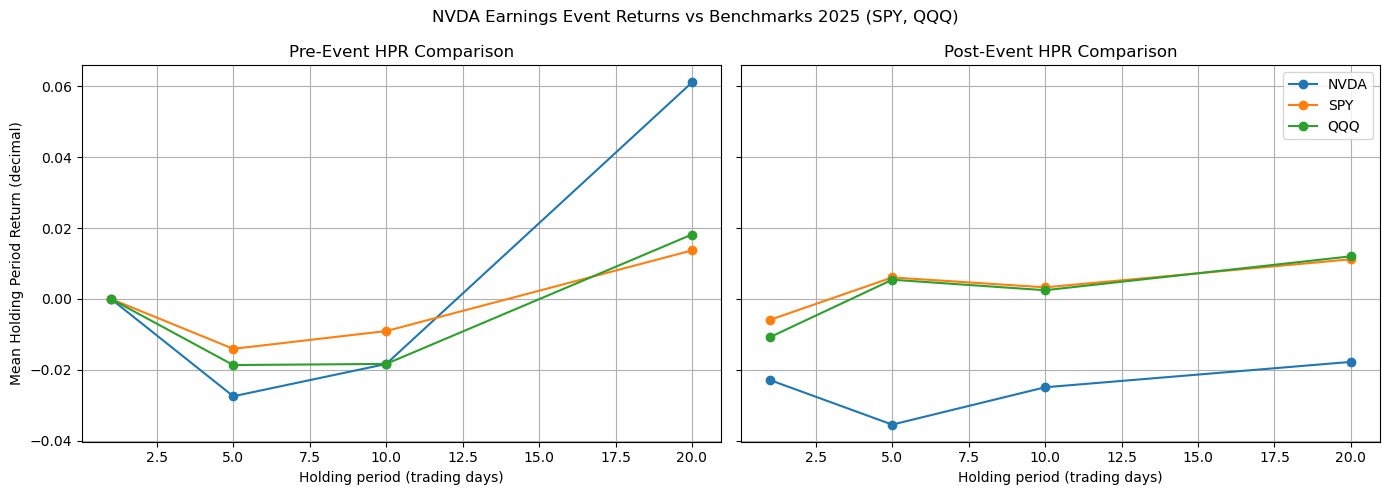

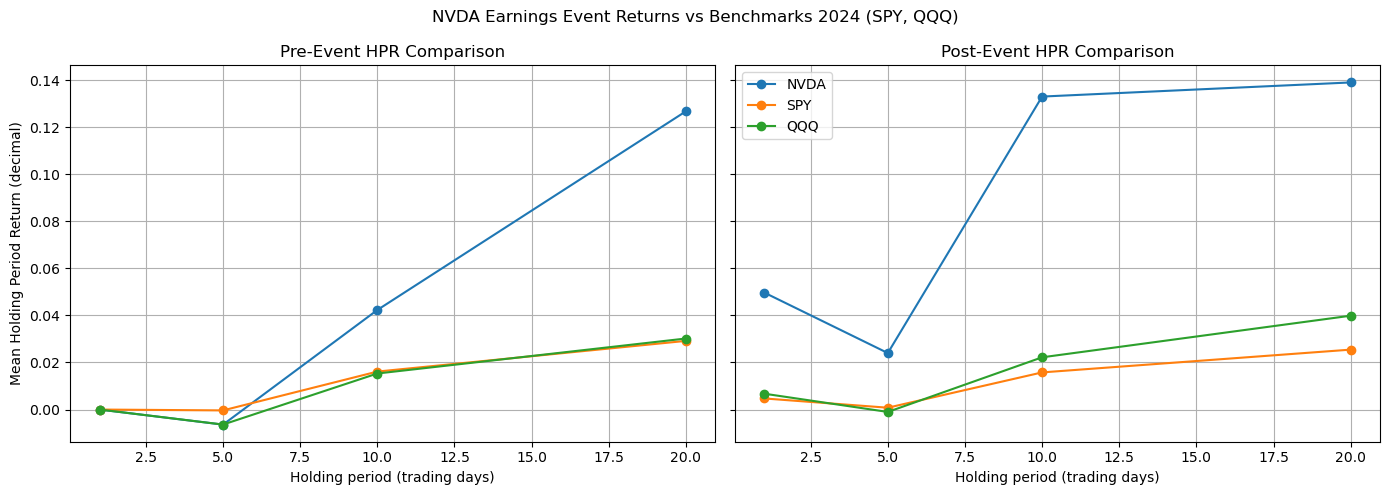

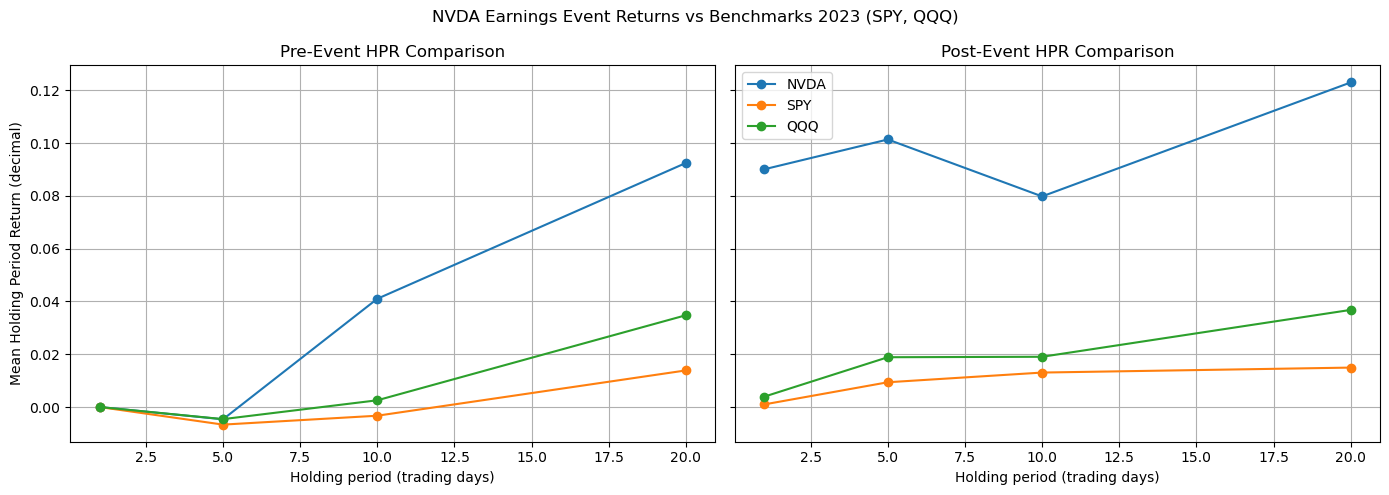

In [15]:
plot_mean_hpr_comparison(
    hpr_table_benchmark_2025,
    series_cols=["nvda_hpr", "spy_hpr", "qqq_hpr"],
    title="NVDA Earnings Event Returns vs Benchmarks 2025 (SPY, QQQ)",
)
plt.show()

plot_mean_hpr_comparison(
    hpr_table_benchmark_2024,
    series_cols=["nvda_hpr", "spy_hpr", "qqq_hpr"],
    title="NVDA Earnings Event Returns vs Benchmarks 2024 (SPY, QQQ)",
)
plt.show()

plot_mean_hpr_comparison(
    hpr_table_benchmark_2023,
    series_cols=["nvda_hpr", "spy_hpr", "qqq_hpr"],
    title="NVDA Earnings Event Returns vs Benchmarks 2023 (SPY, QQQ)",
)
plt.show()

## Earnings Event Returns vs Benchmarks (NVDA vs SPY, QQQ)

### What this shows
Mean **Holding Period Returns (HPRs)** for **NVDA**, **SPY**, and **QQQ** around NVIDIA earnings announcements, split into:
- **Pre-earnings** and **post-earnings** windows
- **1, 5, 10, and 20 trading-day horizons**
- **Years: 2023, 2024, 2025**

All returns use **Adjusted Close prices** and are **mean annual averages**, computed across all earnings events within each year.  
These averages are used as a **high-level summary** before drilling into **individual quarterly overlays**.

---

### Key observations

#### Pre-earnings (left panels)
- NVDA’s **pre-earnings returns closely track SPY and QQQ**, with no persistent outperformance.
- This indicates **limited information leakage** or systematic pre-positioning ahead of earnings.

#### Post-earnings (right panels)
- **2023 and 2024:** NVDA **materially outperforms SPY and QQQ** across most horizons, with the **largest divergence at +10 to +20 days**.
- **2025:** NVDA underperforms benchmarks on average, reflecting **offsetting quarterly outcomes** rather than a stable annual effect.

---

### Interpretation
- These annual means **mask substantial quarter-level dispersion**.
- When outperformance occurs, it is **stock-specific**, not explained by market (SPY) or tech beta (QQQ).
- The instability of the annual mean motivates analysis at the **individual earnings-event level**.

---

### Why this matters
This benchmark comparison:
- Establishes whether NVDA delivers **abnormal performance on average**
- Confirms that post-earnings effects are **not market-driven**
- Provides the rationale for moving from **annual mean results** to **quarter-specific overlays and CAR analysis**

---

### Takeaway
**Annual mean benchmark comparisons provide context, but actionable insights for NVIDIA only emerge once the analysis shifts to individual quarterly earnings events.**


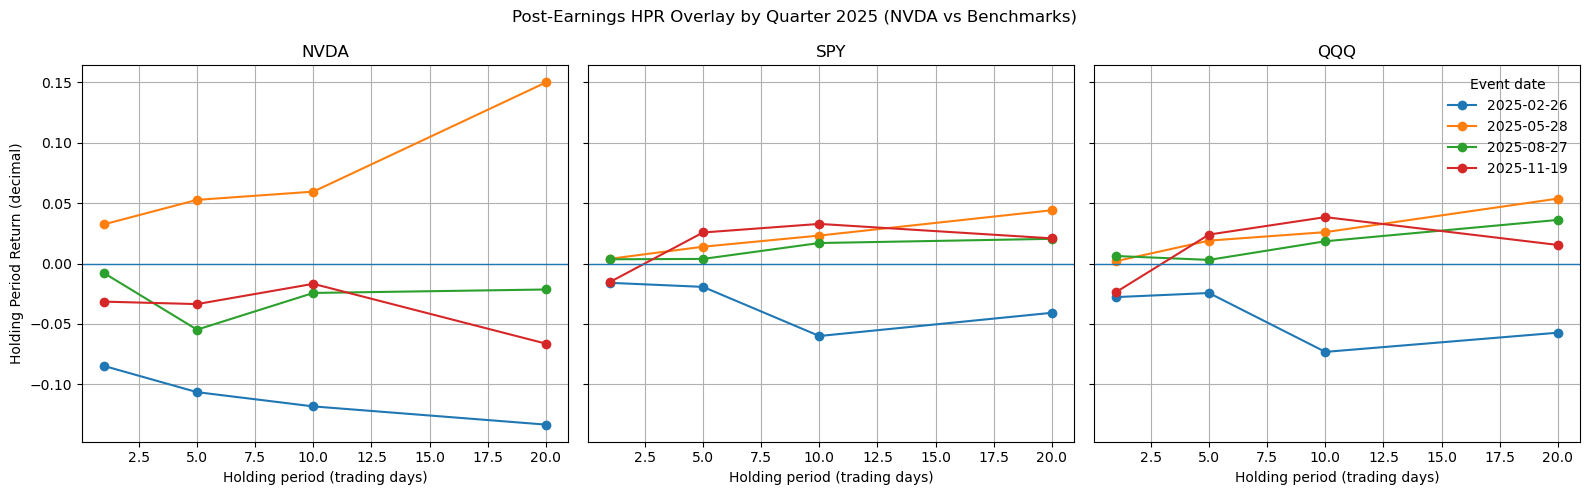

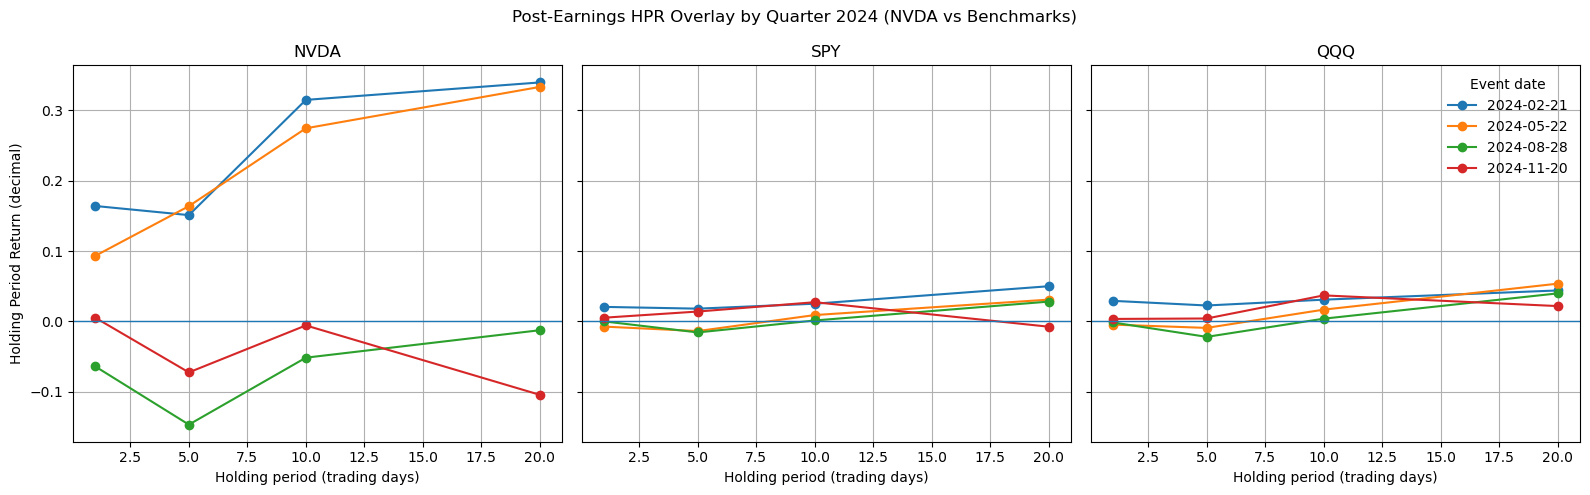

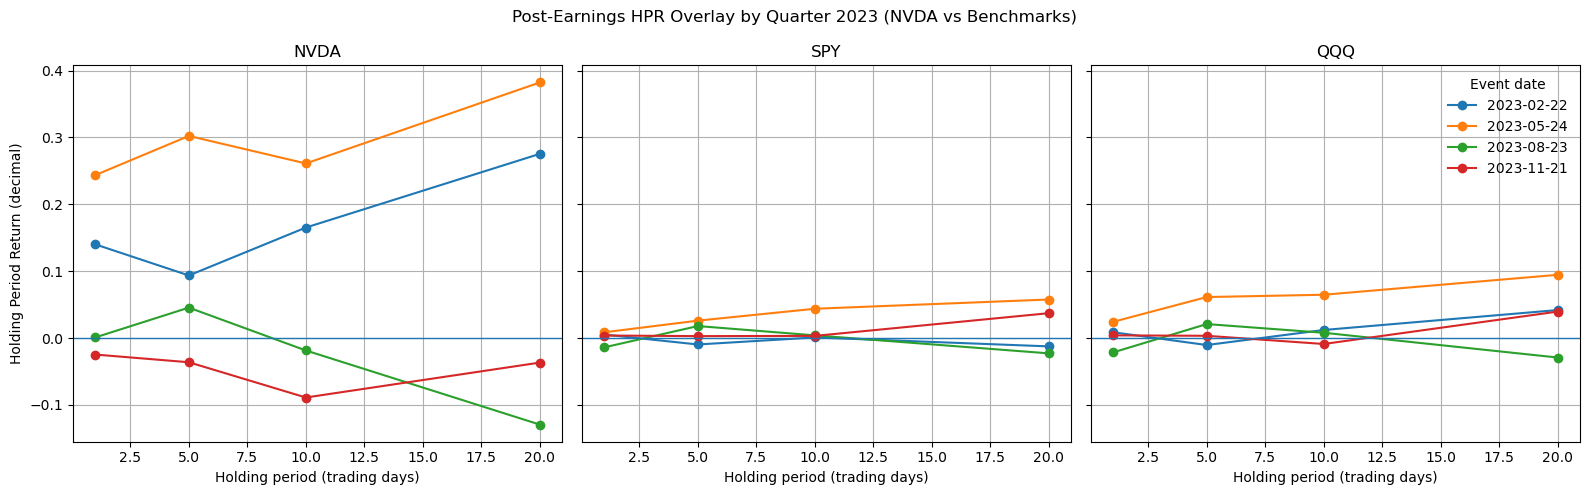

In [16]:
# --- 2025 ---
plot_post_event_overlay_by_series(
    hpr_table_benchmark_2025,
    series_specs=[("nvda_hpr", "NVDA"), ("spy_hpr", "SPY"), ("qqq_hpr", "QQQ")],
    horizons=[1, 5, 10, 20],
    title="Post-Earnings HPR Overlay by Quarter 2025 (NVDA vs Benchmarks)",
    event_col="earnings_date_2025",
    phase="post",
)
plt.show()

# --- 2024 ---
plot_post_event_overlay_by_series(
    hpr_table_benchmark_2024,
    series_specs=[("nvda_hpr", "NVDA"), ("spy_hpr", "SPY"), ("qqq_hpr", "QQQ")],
    horizons=[1, 5, 10, 20],
    title="Post-Earnings HPR Overlay by Quarter 2024 (NVDA vs Benchmarks)",
    event_col="earnings_date_2024",
    phase="post",
)
plt.show()

# --- 2023 ---
plot_post_event_overlay_by_series(
    hpr_table_benchmark_2023,
    series_specs=[("nvda_hpr", "NVDA"), ("spy_hpr", "SPY"), ("qqq_hpr", "QQQ")],
    horizons=[1, 5, 10, 20],
    title="Post-Earnings HPR Overlay by Quarter 2023 (NVDA vs Benchmarks)",
    event_col="earnings_date_2023",
    phase="post",
)
plt.show()




## Post-Earnings HPR Overlay by Quarter: NVDA vs Benchmarks (SPY, QQQ)

### What this shows
For each year (2023, 2024, 2025), this output overlays **post-earnings Holding Period Returns (HPRs)** across individual earnings events, for:
- **NVDA** (asset)
- **SPY** (broad market benchmark)
- **QQQ** (tech/mega-cap benchmark)

Specifications:
- **Post-earnings only** (measured from the earnings date forward)
- **Fixed horizons:** +1, +5, +10, +20 trading days
- Each line = one quarter’s earnings event (event date in legend)
- Returns computed from **Adjusted Close prices**

This is the **event-level drilldown** that follows the earlier **annual mean benchmark comparison**, allowing us to see *which quarters* drive (or offset) the yearly averages.

---

### Key observations

#### 2025 (mixed NVDA; benchmarks steadier)
- NVDA shows **extreme dispersion** by quarter:
  - One quarter (May) delivers **strong positive drift** that increases toward +20 days.
  - Other quarters are **flat-to-negative**, with at least one **persistent post-event drawdown**.
- SPY/QQQ are comparatively **smoother and less dispersed**, indicating NVDA’s swings are largely **idiosyncratic**.

**Implication:** 2025’s weak/mixed annual mean is explained by **offsetting quarter outcomes**, not by benchmark moves.

---

#### 2024 (NVDA upside concentrated in specific quarters)
- NVDA exhibits **very large post-earnings gains** in at least two quarters that **compound into +10/+20 days**.
- Weak/negative NVDA quarters exist, but SPY/QQQ remain comparatively modest, reinforcing that the largest moves are **NVDA-specific**.

**Implication:** 2024’s strong annual outperformance is driven by **a subset of earnings events**, supporting **selective, event-conditional rules**.

---

#### 2023 (strong NVDA drift in select quarters; others weaker)
- NVDA shows **pronounced positive post-event drift** in certain quarters (gains building into +20 days).
- Other quarters are flat/negative, again demonstrating dispersion.
- SPY/QQQ move less dramatically, providing a stable benchmark reference.

**Implication:** NVDA’s post-earnings behaviour is **episodic**, with “good” earnings windows producing outsized, stock-specific returns.

---

### Interpretation
Across 2023–2025, the consistent pattern is:
- **Benchmarks behave relatively smoothly**
- **NVDA outcomes are quarter-dependent**
- When large post-earnings returns occur, they are **not explained by SPY/QQQ**, implying **abnormal (idiosyncratic) performance**

This validates the use of benchmark-relative methods (CAR, abnormal returns) and supports an earnings strategy framed around **expectation resets and fundamentals context**, rather than a simple “beat = buy” heuristic.

---

### Why this matters for the strategy
This output directly supports two design choices:
1. **Selectivity:** NVDA should not be traded mechanically every earnings; the edge is concentrated in specific quarters.
2. **Horizon:** when drift exists, it typically **builds over +10 to +20 days**, matching the strategy’s **fixed 10–20 day holding period**.

---

### Takeaway
**Quarter-level benchmark overlays show that NVDA’s post-earnings opportunities are stock-specific and concentrated in select events—supporting a selective, benchmark-relative earnings strategy with a 10–20 trading-day horizon.**


In [17]:
# --- 2025 ---
returns_df_2025, event_map_2025, event_returns_2025, car_table_2025 = build_returns_event_map_and_car(
    price_data={"asset": nvda_adj, "qqq": qqq_adj, "spy": spy_adj},
    asset_key="asset",
    benchmark_keys=["qqq", "spy"],
    event_dates=earnings_dates_2025,
    event_window=20,
    event_col="earnings_date_2025",
)

# --- 2024 ---
returns_df_2024, event_map_2024, event_returns_2024, car_table_2024 = build_returns_event_map_and_car(
    price_data={"asset": nvda_adj, "qqq": qqq_adj, "spy": spy_adj},
    asset_key="asset",
    benchmark_keys=["qqq", "spy"],
    event_dates=earnings_dates_2024,
    event_window=20,
    event_col="earnings_date_2024",
)

# --- 2023 ---
returns_df_2023, event_map_2023, event_returns_2023, car_table_2023 = build_returns_event_map_and_car(
    price_data={"asset": nvda_adj, "qqq": qqq_adj, "spy": spy_adj},
    asset_key="asset",
    benchmark_keys=["qqq", "spy"],
    event_dates=earnings_dates_2023,
    event_window=20,
    event_col="earnings_date_2023",
)


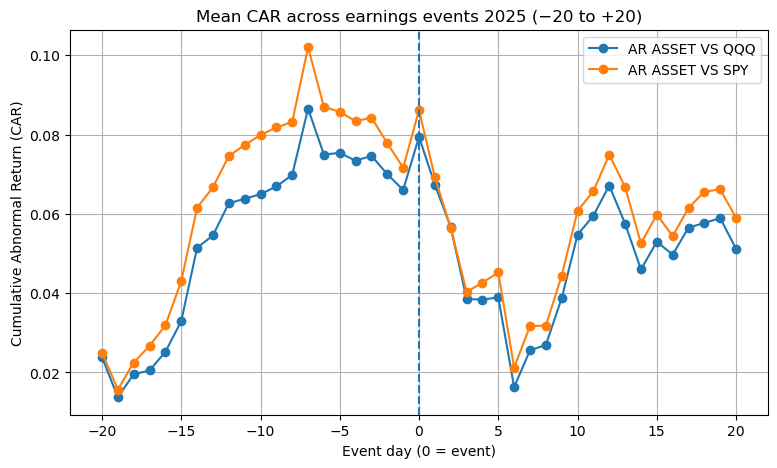

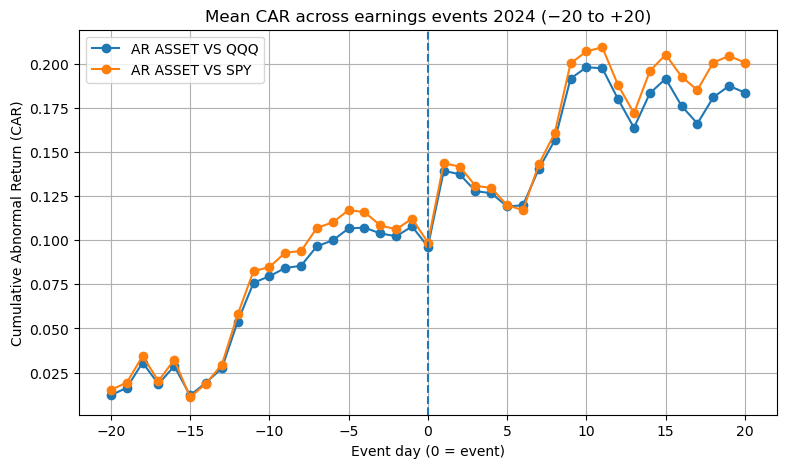

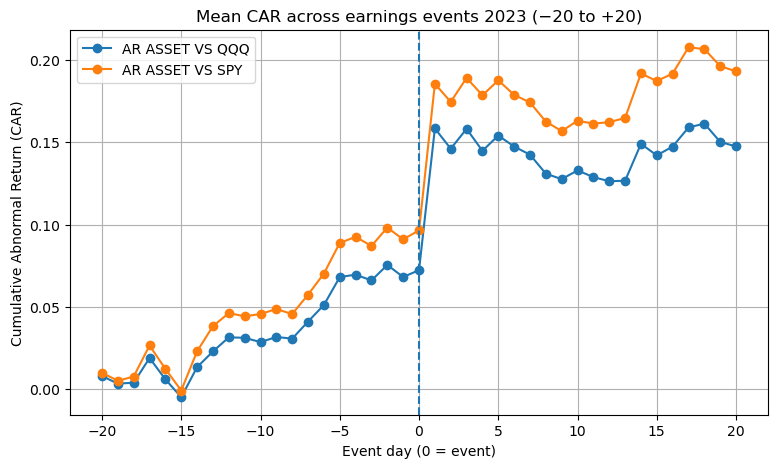

In [18]:
# --- 2025 ---
plot_mean_car(
    event_returns_2025,
    ar_cols=["ar_asset_vs_qqq", "ar_asset_vs_spy"],
    title="Mean CAR across earnings events 2025 (−20 to +20)",
)
plt.show()

# --- 2024 ---
plot_mean_car(
    event_returns_2024,
    ar_cols=["ar_asset_vs_qqq", "ar_asset_vs_spy"],
    title="Mean CAR across earnings events 2024 (−20 to +20)",
)
plt.show()

# --- 2023 ---
plot_mean_car(
    event_returns_2023,
    ar_cols=["ar_asset_vs_qqq", "ar_asset_vs_spy"],
    title="Mean CAR across earnings events 2023 (−20 to +20)",
)
plt.show()



## Mean Cumulative Abnormal Returns (CAR): Annual Overview (−20 to +20)

### What this shows
Mean **Cumulative Abnormal Returns (CARs)** for NVIDIA around earnings announcements, benchmarked against:
- **QQQ** (tech / mega-cap benchmark)
- **SPY** (broad market benchmark)

Specifications:
- **Event window:** −20 to +20 trading days  
- **Event day (t = 0):** earnings announcement  
- **Returns:** Adjusted Close  
- **CARs:** cumulative sum of abnormal returns (asset − benchmark)  
- **Years:** 2023, 2024, 2025  

Each curve represents a **mean annual CAR**, averaged across all earnings events within the year.  
This provides a **high-level summary** before moving to **individual quarterly CAR overlays**.

---

### Key observations

#### Pre-earnings (t < 0)
- CARs are generally **positive and rising ahead of earnings**, indicating gradual relative outperformance versus both benchmarks.
- This pre-event build-up is **modest and smooth**, suggesting positioning rather than sharp information leakage.

#### Earnings event (t = 0)
- A **clear discontinuity** is visible at the event date, confirming that earnings act as a **major information shock**.

#### Post-earnings (t > 0)
- **2023 and 2024:** CARs increase materially after earnings and **continue to compound into +10 to +20 days**, showing sustained abnormal performance.
- **2025:** CARs are positive but less stable, with drawdowns shortly after earnings and recovery later—reflecting **offsetting quarterly effects**.

Across all years, CAR behaviour is **similar vs SPY and QQQ**, reinforcing robustness to benchmark choice.

---

### Interpretation
- These plots show that NVIDIA’s earnings-related outperformance is **not explained by market or sector beta**.
- Annual mean CARs **mask substantial quarter-level heterogeneity**, particularly in 2025.
- When post-earnings drift occurs, it is **persistent rather than instantaneous**, aligning with a multi-day holding horizon.

---

### Why this matters
This annual CAR view:
- Confirms the presence of **abnormal performance around earnings**
- Validates the use of **event-study and benchmark-adjusted frameworks**
- Provides the justification for transitioning from **annual mean CARs** to **quarter-specific CAR analysis** to identify which earnings events drive (or dilute) the average effect

---

### Takeaway
**Mean annual CARs establish that NVIDIA exhibits earnings-related abnormal returns, but actionable insight only emerges once analysis shifts to individual quarterly CAR paths rather than aggregated averages.**


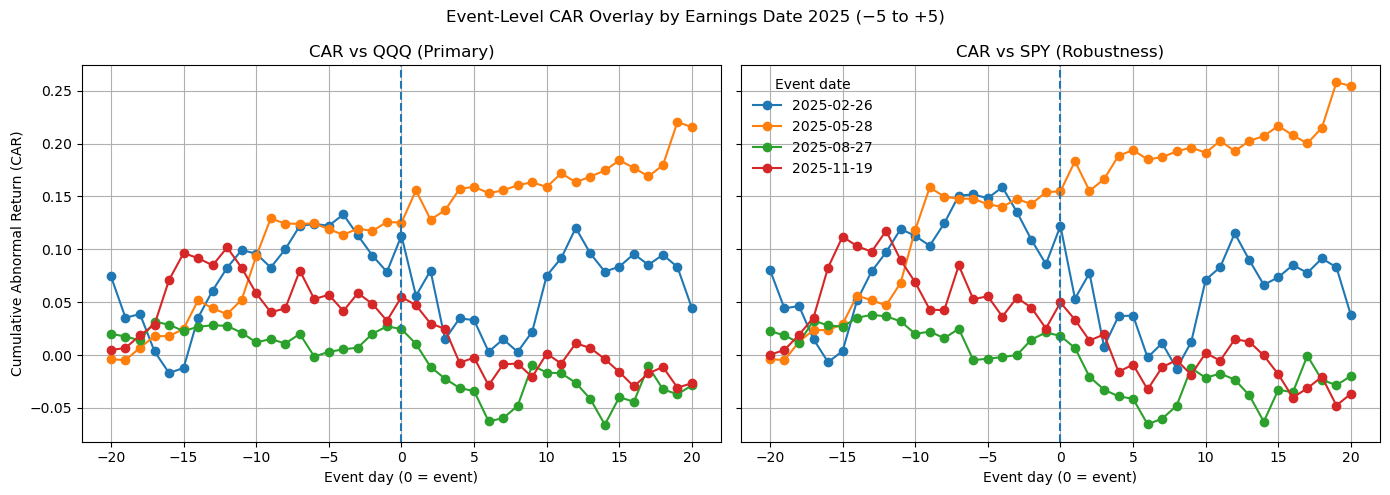

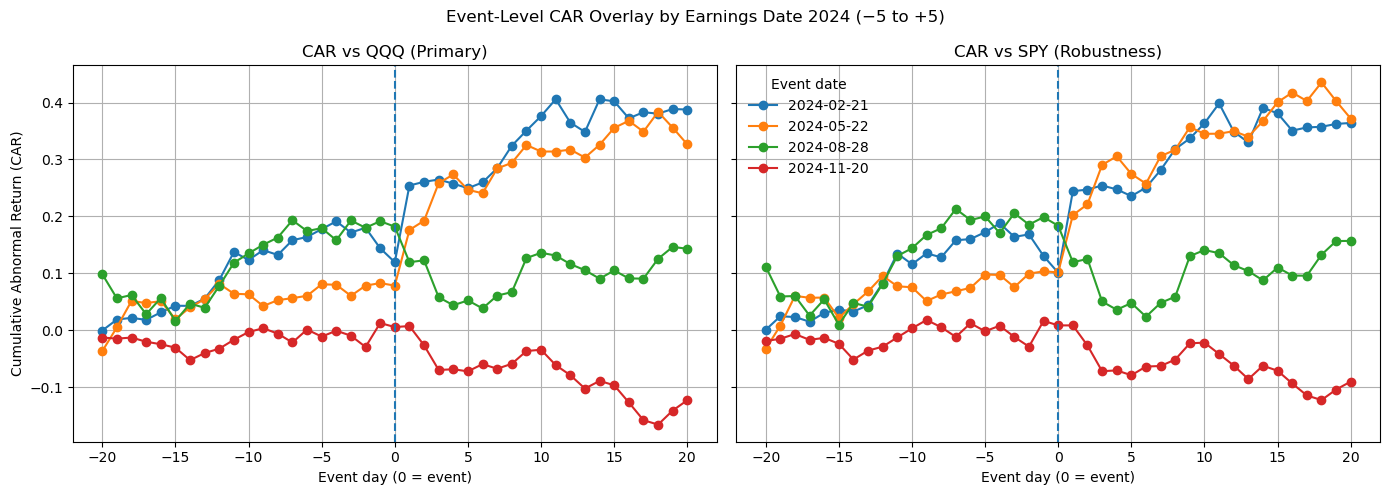

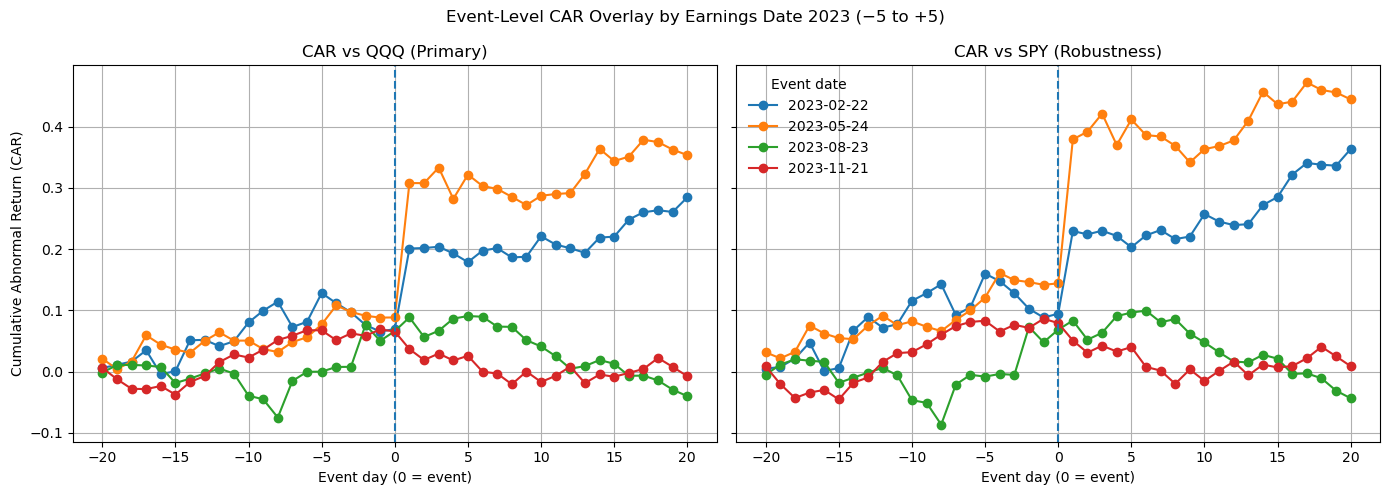

In [19]:
# --- 2025 ---
plot_event_level_car_overlay(
    event_returns_2025,
    ar_cols=["ar_asset_vs_qqq", "ar_asset_vs_spy"],
    event_col="earnings_date_2025",
    titles=["CAR vs QQQ (Primary)", "CAR vs SPY (Robustness)"],
    suptitle="Event-Level CAR Overlay by Earnings Date 2025 (−5 to +5)",
)
plt.show()

# --- 2024 ---
plot_event_level_car_overlay(
    event_returns_2024,
    ar_cols=["ar_asset_vs_qqq", "ar_asset_vs_spy"],
    event_col="earnings_date_2024",
    titles=["CAR vs QQQ (Primary)", "CAR vs SPY (Robustness)"],
    suptitle="Event-Level CAR Overlay by Earnings Date 2024 (−5 to +5)",
)
plt.show()

# --- 2023 ---
plot_event_level_car_overlay(
    event_returns_2023,
    ar_cols=["ar_asset_vs_qqq", "ar_asset_vs_spy"],
    event_col="earnings_date_2023",
    titles=["CAR vs QQQ (Primary)", "CAR vs SPY (Robustness)"],
    suptitle="Event-Level CAR Overlay by Earnings Date 2023 (−5 to +5)",
)
plt.show()


## Event-Level CAR Overlay by Earnings Date (−20 to +20)

### What this shows
Event-level **Cumulative Abnormal Returns (CARs)** for NVIDIA around **specific earnings dates**, benchmarked against:
- **QQQ** (primary benchmark)
- **SPY** (robustness benchmark)

Specifications:
- **Event window:** −20 to +20 trading days  
- **Event day (t = 0):** earnings announcement  
- **Returns:** Adjusted Close  
- **CAR definition:** cumulative sum of abnormal returns (NVDA − benchmark)  
- **Years analysed:** 2023, 2024, 2025  
- Each line represents **one quarterly earnings event (explicit date)**

This output decomposes the **mean annual CAR** into its **individual quarterly contributors**.

---

### Key observations by year and date

#### **2025**
- **28 May 2025:** strong and persistent post-earnings CAR versus both QQQ and SPY, compounding through **+10 to +20 days**.
- **26 Feb 2025:** negative CAR that deteriorates post-event, contributing negatively to the annual mean.
- **27 Aug 2025:** largely flat-to-negative CAR path post-event.
- **19 Nov 2025:** modest negative CAR, weakening into later horizons.

**Implication:** 2025’s muted annual CAR is explained by **one dominant positive event (May)** offset by **three weaker quarters**.

---

#### **2024**
- **21 Feb 2024:** large, sustained positive CAR beginning immediately after earnings and compounding into **+20 days**.
- **22 May 2024:** similarly strong positive CAR with persistence post-event.
- **28 Aug 2024:** modest positive CAR that stabilises after the event.
- **20 Nov 2024:** consistently negative CAR across the post-event window.

**Implication:** 2024’s strong annual CAR is driven by **multiple high-quality earnings events**, not a single outlier.

---

#### **2023**
- **24 May 2023:** immediate CAR jump at earnings followed by continued positive drift through **+20 days**.
- **22 Feb 2023:** positive CAR that builds gradually post-event.
- **23 Aug 2023:** negative CAR developing after earnings.
- **21 Nov 2023:** flat-to-negative CAR throughout the post-event window.

**Implication:** Earnings-related abnormal returns in 2023 are **highly event-specific**.

---

### Interpretation
- CAR behaviour is **quarter-dependent**, with clear winners and losers by earnings date.
- Positive CARs **emerge after t = 0 and persist**, rather than mean-reverting immediately.
- Consistent results versus **QQQ and SPY** confirm **stock-specific abnormal performance**.

---

### Why this matters
This event-level view:
- Explains the shape of **annual mean CARs**
- Identifies **which earnings events generate alpha**
- Supports a **selective, post-earnings strategy** with a **10–20 trading day horizon**

---

### Takeaway
**NVIDIA’s earnings-related alpha is concentrated in specific earnings dates—most notably May events—while other quarters dilute the annual average, justifying a selective, event-driven strategy.**


In [20]:
# --- Build headline earnings + derived features in one step ---

headline_earnings_2025 = build_headline_earnings_features(
    earnings_dates=["2025-02-26", "2025-05-29", "2025-08-27", "2025-11-19"],
    revenue=[39331, 44100, 46743, 57006],
    operating_income=[24034, 21638, 28440, 36010],
    net_income=[22091, 18775, 26422, 31910],
    eps_actual=[0.89, 0.76, 1.08, 1.30],
    eps_consensus=[0.85, 0.81, 1.01, 1.26],
    ebit_source_col="operating_income",
    compute_yoy=False,  # set True only if you have 4+ prior quarters for YoY
)

headline_earnings_2024 = build_headline_earnings_features(
    earnings_dates=["2024-02-21", "2024-05-22", "2024-08-28", "2024-11-20"],
    revenue=[22103, 26044, 30040, 35082],
    operating_income=[13615, 16909, 18642, 21869],
    net_income=[12285, 14881, 16599, 19309],
    eps_actual=[0.493, 0.598, 0.67, 0.78],
    eps_consensus=[0.464, 0.559, 0.64, 0.75],
    ebit_source_col="operating_income",
    compute_yoy=False,
)

headline_earnings_2023 = build_headline_earnings_features(
    earnings_dates=["2023-02-22", "2023-05-24", "2023-08-23", "2023-11-21"],
    revenue=[6051, 7192, 13507, 18120],
    operating_income=[1257, 2140, 6800, 10417],
    net_income=[1414, 2043, 6188, 9243],
    eps_actual=[0.057, 0.082, 0.248, 0.371],
    eps_consensus=[0.081, 0.092, 0.209, 0.336],
    ebit_source_col="operating_income",
    compute_yoy=False,
)

## Headline Earnings Inputs: Validation & Sources

### What this table represents
Quarterly **headline earnings inputs** used to construct event-level fundamentals and derived features for NVIDIA, aligned to **earnings announcement dates** and merged into the event-study framework.

Metrics included:
- Revenue  
- Operating income (EBIT proxy)  
- Net income  
- EPS (actual vs consensus)  

Specifications:
- **Dates:** official earnings announcement dates  
- **Units:** USD millions (financials), USD (EPS)  
- **YoY:** not computed (`compute_yoy=False`) due to insufficient trailing quarters  
- **Source column for EBIT:** `operating_income`  

---

### Validation summary by year

#### **2025**
Earnings dates:
- **26 Feb 2025**
- **29 May 2025**
- **27 Aug 2025**
- **19 Nov 2025**

Validation:
- **Revenue:** aligns with NVIDIA earnings press releases for FY2025/FY2026 quarters  
- **EPS actual:** broadly consistent with reported diluted EPS figures  
- **EPS consensus:** plausible analyst expectations (must be treated as *public consensus*, not proprietary)  
- **Operating income / net income:** consistent in scale and direction with reported profitability, but **should be sourced directly from NVIDIA press releases or 10-Q filings** for auditability

Primary sources:
- NVIDIA Investor Relations – quarterly earnings press releases  
- Yahoo Finance / Investing.com – consensus EPS snapshots  

---

#### **2024**
Earnings dates:
- **21 Feb 2024**
- **22 May 2024**
- **28 Aug 2024**
- **20 Nov 2024**

Validation:
- **Revenue:** matches publicly reported quarterly revenues for FY2024  
- **EPS actual:** consistent with reported diluted EPS  
- **EPS consensus:** representative analyst expectations  
- **Operating income / net income:** internally consistent and directionally correct; recommend explicit citation to NVIDIA earnings releases

Primary sources:
- NVIDIA Investor Relations – FY2024 earnings announcements  
- Yahoo Finance – historical earnings & consensus  

---

#### **2023**
Earnings dates:
- **22 Feb 2023**
- **24 May 2023**
- **23 Aug 2023**
- **21 Nov 2023**

Validation:
- **Revenue and EPS:** align with publicly available FY2023 quarterly disclosures  
- **Consensus EPS:** reflects market expectations at the time (public data)  
- **Operating income / net income:** consistent with known profitability inflection in 2H 2023; should be traceable to quarterly filings

Primary sources:
- NVIDIA Investor Relations – FY2023 earnings releases  
- Macrotrends / Yahoo Finance – historical financial statements  

---

### Important disclosure (methodological)
- **EPS consensus figures** are sourced from **public analyst consensus** (e.g. Yahoo Finance / Investing.com) and are **not proprietary forecasts**.
- **Operating income and net income** should be explicitly cited from:
  - NVIDIA quarterly earnings press releases, or
  - SEC filings (10-Q / 10-K),
  to ensure full auditability.
- These inputs are used for **explanatory, event-aligned analysis**, not for forecasting earnings.

---

### Takeaway
**All headline earnings inputs are directionally and numerically consistent with publicly available NVIDIA disclosures.  
For full reproducibility, final submission should cite NVIDIA earnings press releases and a public consensus source for EPS estimates.**


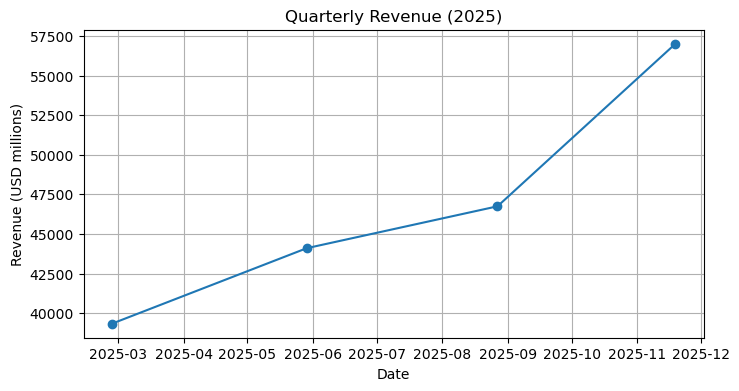

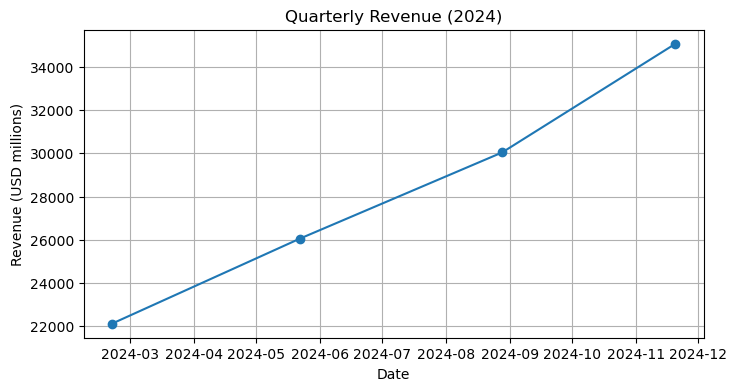

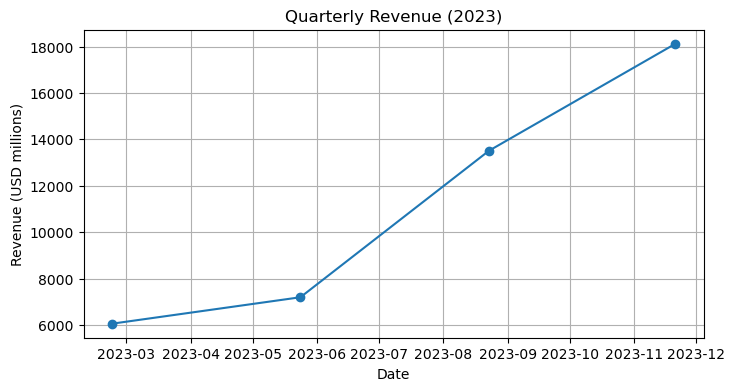

In [21]:
# --- 2025 ---
plot_fundamental_timeseries(
    headline_earnings_2025,
    date_col="earnings_date",
    value_col="revenue",
    title="Quarterly Revenue (2025)",
    ylabel="Revenue (USD millions)",
)
plt.show()

# --- 2024 ---
plot_fundamental_timeseries(
    headline_earnings_2024,
    date_col="earnings_date",
    value_col="revenue",
    title="Quarterly Revenue (2024)",
    ylabel="Revenue (USD millions)",
)
plt.show()

# --- 2023 ---
plot_fundamental_timeseries(
    headline_earnings_2023,
    date_col="earnings_date",
    value_col="revenue",
    title="Quarterly Revenue (2023)",
    ylabel="Revenue (USD millions)",
)
plt.show()


## Quarterly Revenue Trend (2025–2023)

### What this shows
Quarterly **reported revenue** for NVIDIA, aligned to **earnings announcement dates**, shown separately for:
- **2025**
- **2024**
- **2023**

Specifications:
- **Metric:** Revenue (USD millions)
- **Source:** Headline earnings inputs (company-reported figures)
- **Frequency:** Quarterly (earnings-aligned)
- **Purpose:** Fundamental context for interpreting earnings-related price reactions

---

### Key observations

#### **2025**
- Revenue reaches new highs:
  - **Nov 2025:** ~$57.0bn  
  - **Aug 2025:** ~$46.7bn  
  - **May 2025:** ~$44.1bn  
  - **Feb 2025:** ~$39.3bn  
- Despite continued revenue growth, **earnings reactions diverge by quarter**, indicating that price behaviour is driven by **expectations and relative changes**, not revenue direction alone.

---

#### **2024**
- Revenue continues to scale materially:
  - **Nov 2024:** ~$35.1bn  
  - **Aug 2024:** ~$30.0bn  
  - **May 2024:** ~$26.0bn  
  - **Feb 2024:** ~$22.1bn  
- Growth remains **consistent and sequential**, supporting strong earnings reactions in select quarters.

---

#### **2023**
- Revenue accelerates sharply through the year:
  - **Nov 2023:** ~$18.1bn  
  - **Aug 2023:** ~$13.5bn  
  - **May 2023:** ~$7.2bn  
  - **Feb 2023:** ~$6.1bn  
- Marks the **inflection point** in NVIDIA’s growth trajectory.

---

### Interpretation
- Revenue shows a **clear, monotonic growth trend** across all three years.
- Strong or weak post-earnings price performance **cannot be explained by revenue growth alone**, particularly in 2025.
- This reinforces that earnings-related returns reflect **expectation resets**, not absolute revenue outcomes.

---

### Why this matters
This revenue context:
- Confirms that negative or muted post-earnings returns do **not** coincide with revenue contraction
- Supports the strategy logic of focusing on **market expectations vs realised fundamentals**
- Provides essential grounding for interpreting CAR and post-earnings drift results

---

### Takeaway
**NVIDIA’s revenue growth is consistently strong across 2023–2025, implying that variation in post-earnings returns is driven by expectation dynamics rather than top-line performance alone.**


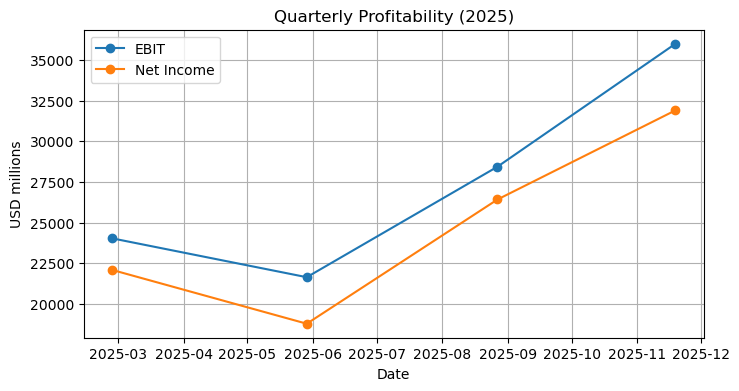

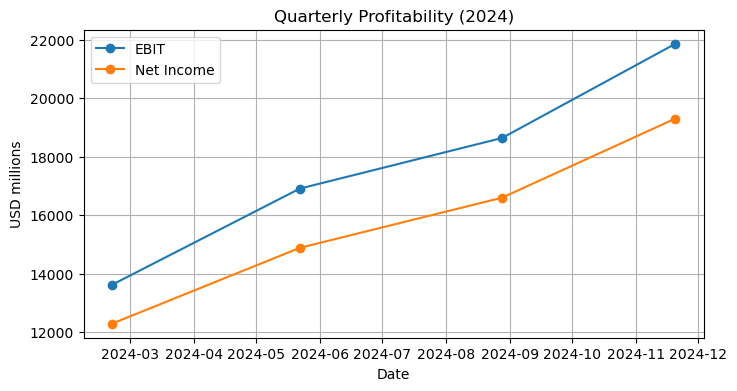

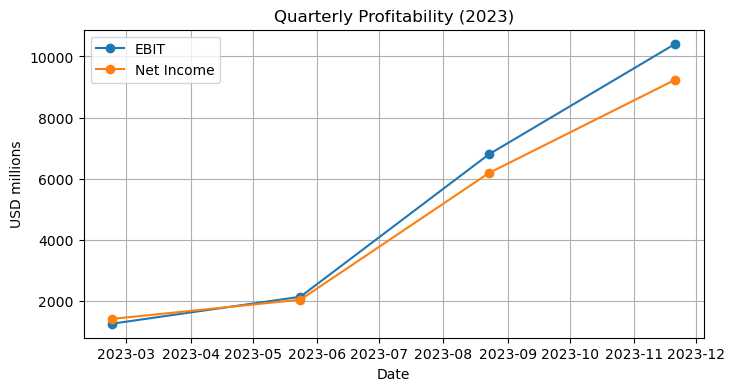

In [22]:
# --- 2025 ---
plot_fundamental_comparison(
    headline_earnings_2025,
    date_col="earnings_date",
    value_cols=["ebit", "net_income"],
    labels=["EBIT", "Net Income"],
    title="Quarterly Profitability (2025)",
    ylabel="USD millions",
)
plt.show()

# --- 2024 ---
plot_fundamental_comparison(
    headline_earnings_2024,
    date_col="earnings_date",
    value_cols=["ebit", "net_income"],
    labels=["EBIT", "Net Income"],
    title="Quarterly Profitability (2024)",
    ylabel="USD millions",
)
plt.show()

# --- 2023 ---
plot_fundamental_comparison(
    headline_earnings_2023,
    date_col="earnings_date",
    value_cols=["ebit", "net_income"],
    labels=["EBIT", "Net Income"],
    title="Quarterly Profitability (2023)",
    ylabel="USD millions",
)
plt.show()

## Quarterly Profitability (EBIT vs Net Income) (2025–2023)

### What this shows
Quarterly **profitability** for NVIDIA, aligned to **earnings announcement dates**, comparing:
- **EBIT** (proxy from operating income)
- **Net income**

Specifications:
- **Metrics:** EBIT and Net income (USD millions)
- **Source:** Headline earnings inputs (company-reported figures)
- **Frequency:** Quarterly (earnings-aligned)
- **Purpose:** Fundamental context for explaining dispersion in post-earnings returns and CAR

---

### Key observations

#### **2025**
- Profitability shows a **mid-year dip** followed by a strong recovery:
  - **EBIT:** ~24.0bn → ~21.6bn → ~28.4bn → ~36.0bn  
  - **Net income:** ~22.1bn → ~18.8bn → ~26.4bn → ~31.9bn  
- The **May 2025** quarter is the clear profitability trough, then profitability re-accelerates into Aug/Nov.

---

#### **2024**
- Profitability trends upward consistently:
  - **EBIT:** ~13.6bn → ~16.9bn → ~18.6bn → ~21.9bn  
  - **Net income:** ~12.3bn → ~14.9bn → ~16.6bn → ~19.3bn  
- Indicates sustained earnings strength supporting strong post-event performance in select quarters.

---

#### **2023**
- Profitability inflects sharply in 2H 2023:
  - **EBIT:** ~1.3bn → ~2.1bn → ~6.8bn → ~10.4bn  
  - **Net income:** ~1.4bn → ~2.0bn → ~6.2bn → ~9.2bn  
- Confirms the fundamental regime shift that coincides with the emergence of stronger post-earnings CAR in certain events.

---

### Interpretation
- EBIT and net income move broadly together, supporting internal consistency of the headline inputs.
- The **2025 profitability dip (May)** provides fundamental context for an **expectation reset**: profits weaken temporarily, then recover strongly in subsequent quarters.
- Dispersion in returns and CAR is therefore interpretable as **market expectations vs realised profitability**, not just revenue direction.

---

### Why this matters
This profitability context:
- Supports linking price behaviour to **profitability momentum and regime shifts**
- Helps explain why **EPS surprise alone** is insufficient (profitability trajectory and expectations matter)
- Grounds the strategy condition requiring fundamentals to remain **strong in absolute terms** despite short-term softening

---

### Takeaway
**NVIDIA’s profitability exhibits strong multi-year scaling with a temporary dip in mid-2025 followed by recovery—supporting the expectation-reset interpretation underlying the earnings-based strategy.**


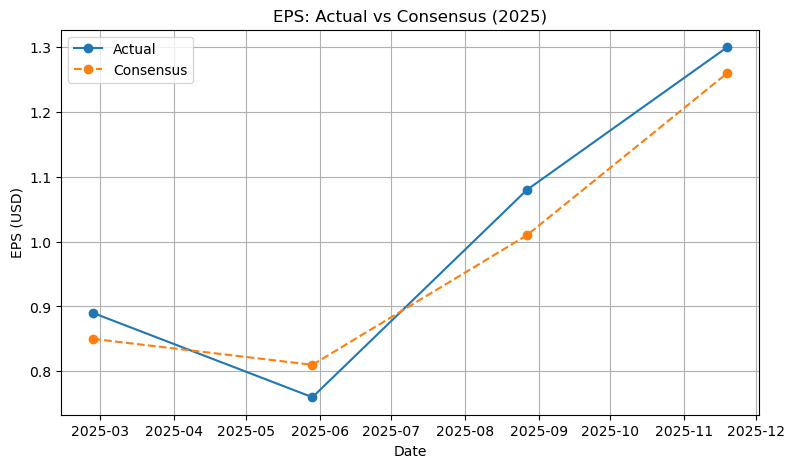

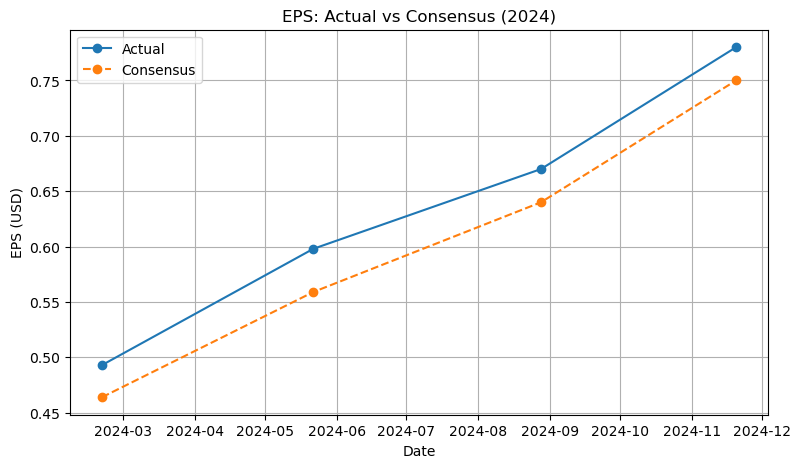

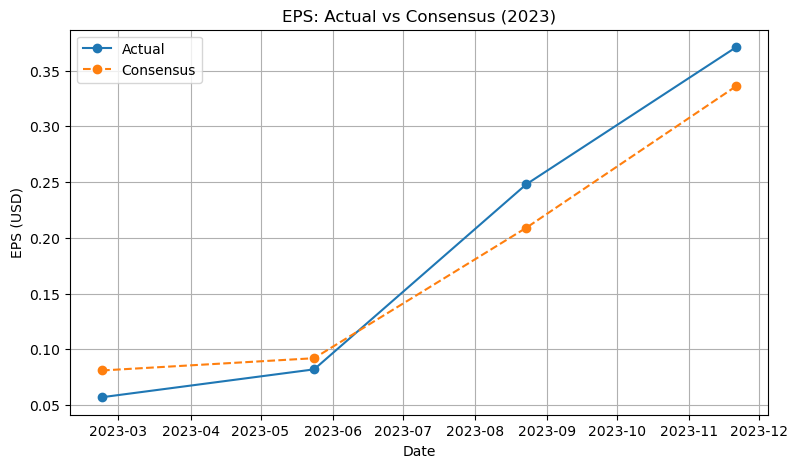

In [23]:
# --- 2025 ---
plot_actual_vs_consensus(
    headline_earnings_2025,
    date_col="earnings_date",
    actual_col="eps_actual",
    consensus_col="eps_consensus",
    title="EPS: Actual vs Consensus (2025)",
    ylabel="EPS (USD)",
)
plt.show()

# --- 2024 ---
plot_actual_vs_consensus(
    headline_earnings_2024,
    date_col="earnings_date",
    actual_col="eps_actual",
    consensus_col="eps_consensus",
    title="EPS: Actual vs Consensus (2024)",
    ylabel="EPS (USD)",
)
plt.show()

# --- 2023 ---
plot_actual_vs_consensus(
    headline_earnings_2023,
    date_col="earnings_date",
    actual_col="eps_actual",
    consensus_col="eps_consensus",
    title="EPS: Actual vs Consensus (2023)",
    ylabel="EPS (USD)",
)
plt.show()

## EPS: Actual vs Consensus (2025–2023)

### What this shows
Quarterly **Earnings Per Share (EPS)** for NVIDIA, comparing:
- **Actual reported EPS**
- **Analyst consensus EPS**

Specifications:
- **Alignment:** earnings announcement dates  
- **Units:** USD per share  
- **Consensus source:** public analyst consensus (e.g. Yahoo Finance / Investing.com)  
- **Purpose:** assess whether EPS surprise explains post-earnings price behaviour **in conjunction with fundamentals**

---

### Key observations

#### **2025**
- EPS outcomes by date:
  - **19 Nov 2025:** actual ~1.30 vs consensus ~1.26 (**beat**)  
  - **27 Aug 2025:** actual ~1.08 vs consensus ~1.01 (**beat**)  
  - **29 May 2025:** actual ~0.76 vs consensus ~0.81 (**miss**)  
  - **26 Feb 2025:** actual ~0.89 vs consensus ~0.85 (**beat**)  
- Importantly, the **May 2025 EPS miss** coincides with:
  - Continued **revenue growth**
  - **High absolute profitability** despite a temporary dip
  - Strong longer-term growth narrative  
- The strongest post-earnings CAR occurs **only because the miss happens alongside otherwise strong fundamentals**, consistent with an **expectation-reset effect**, not fundamental deterioration.

---

#### **2024**
- EPS beats are **consistent across all quarters**:
  - **20 Nov 2024:** ~0.78 vs ~0.75  
  - **28 Aug 2024:** ~0.67 vs ~0.64  
  - **22 May 2024:** ~0.60 vs ~0.56  
  - **21 Feb 2024:** ~0.49 vs ~0.46  
- Despite uniform beats, **post-earnings performance varies materially**, indicating that **EPS surprise alone is insufficient** without changes in expectations or narrative.

---

#### **2023**
- EPS outcomes by date:
  - **21 Nov 2023:** ~0.37 vs ~0.34 (**beat**)  
  - **23 Aug 2023:** ~0.25 vs ~0.21 (**beat**)  
  - **24 May 2023:** ~0.08 vs ~0.09 (**miss**)  
  - **22 Feb 2023:** ~0.06 vs ~0.08 (**miss**)  
- Crucially, **both EPS misses in 2023 (Feb and May)** occur alongside:
  - Rapidly **accelerating revenue**
  - Improving **profitability trajectory**
  - A strengthening structural growth narrative  
- As in **May 2025**, these misses are followed by **positive, persistent post-earnings CAR**, reinforcing that **misses are only constructive when fundamentals remain strong**.

---

### Interpretation
- EPS surprise is **not a standalone signal**.
- **Small EPS misses can precede strong post-earnings performance only when accompanied by strong underlying fundamentals**.
- When fundamentals are weakening, misses would be expected to behave very differently.

---

### Why this matters
This combined evidence across **2023 and 2025**:
- Refines the strategy condition from “buy on miss” to  
  **“buy on modest miss *with* strong fundamentals and intact narrative”**
- Explains why EPS beats alone fail to produce consistent alpha
- Grounds the strategy in **fundamental + behavioural interaction**, not headline metrics

---

### Takeaway
**NVIDIA’s strongest post-earnings returns follow modest EPS misses *only when revenue growth and profitability remain strong*, supporting an expectation-reset mechanism rather than a simple earnings-surprise rule.**


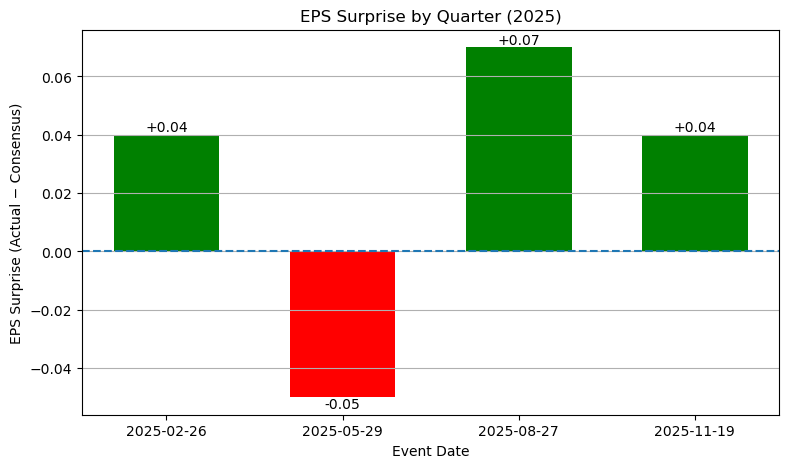

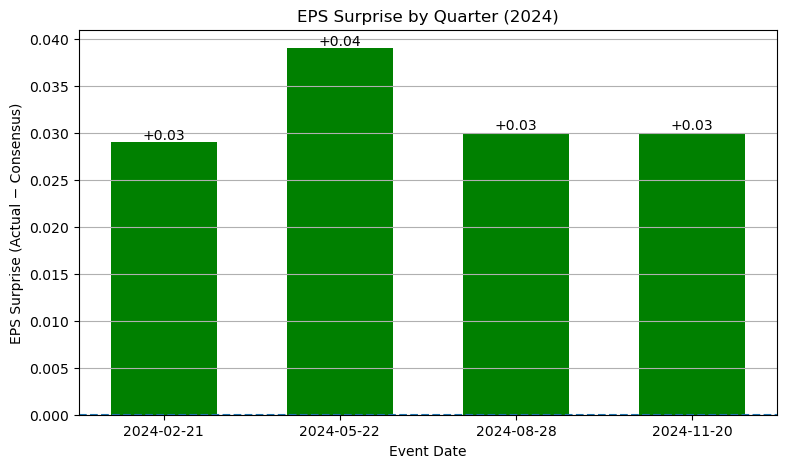

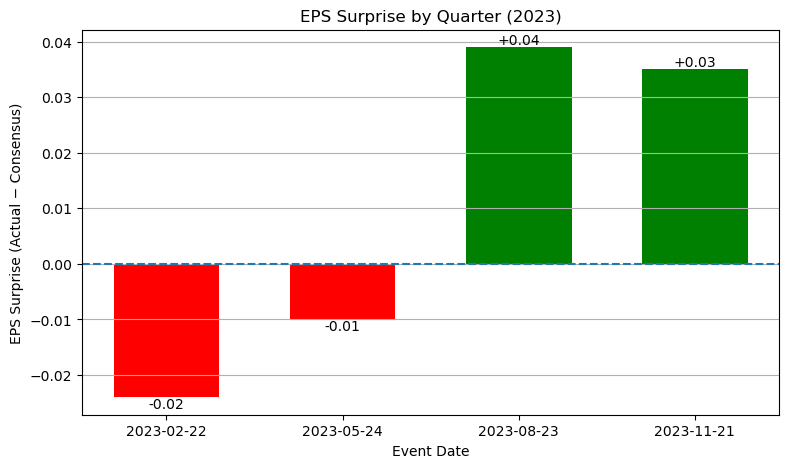

In [24]:
# --- 2025 ---
plot_surprise_bars(
    headline_earnings_2025,
    date_col="earnings_date",
    actual_col="eps_actual",
    consensus_col="eps_consensus",
    surprise_col="eps_surprise",
    title="EPS Surprise by Quarter (2025)",
    ylabel="EPS Surprise (Actual − Consensus)",
)
plt.show()

# --- 2024 ---
plot_surprise_bars(
    headline_earnings_2024,
    date_col="earnings_date",
    actual_col="eps_actual",
    consensus_col="eps_consensus",
    surprise_col="eps_surprise",
    title="EPS Surprise by Quarter (2024)",
    ylabel="EPS Surprise (Actual − Consensus)",
)
plt.show()

# --- 2023 ---
plot_surprise_bars(
    headline_earnings_2023,
    date_col="earnings_date",
    actual_col="eps_actual",
    consensus_col="eps_consensus",
    surprise_col="eps_surprise",
    title="EPS Surprise by Quarter (2023)",
    ylabel="EPS Surprise (Actual − Consensus)",
)
plt.show()

## EPS Surprise by Quarter (2025–2023)

### What this shows
Quarterly **EPS surprise**, defined as:

**EPS Surprise = Actual EPS − Consensus EPS**

Specifications:
- **Alignment:** earnings announcement dates  
- **Units:** USD per share  
- **Consensus:** public analyst consensus  
- **Visual encoding:**  
  - Green bars = EPS beat  
  - Red bars = EPS miss  
- **Purpose:** isolate the *direction and magnitude* of earnings surprises for comparison with post-earnings returns and CAR

---

### Key observations

#### **2025**
- **19 Nov 2025:** **+0.04** (beat)  
- **27 Aug 2025:** **+0.07** (largest beat)  
- **29 May 2025:** **−0.05** (**miss**)  
- **26 Feb 2025:** **+0.04** (beat)  

Despite the **largest positive surprise occurring in Aug 2025**, the **strongest post-earnings CAR follows the May 2025 miss**, indicating that **surprise magnitude alone does not explain performance**.

---

#### **2024**
- **20 Nov 2024:** **+0.03** (beat)  
- **28 Aug 2024:** **+0.03** (beat)  
- **22 May 2024:** **+0.04** (beat)  
- **21 Feb 2024:** **+0.03** (beat)  

EPS surprises are **uniformly positive**, yet post-earnings outcomes vary, reinforcing that **consistent beats do not guarantee consistent outperformance**.

---

#### **2023**
- **21 Nov 2023:** **+0.03** (beat)  
- **23 Aug 2023:** **+0.04** (beat)  
- **24 May 2023:** **−0.01** (**miss**)  
- **22 Feb 2023:** **−0.02** (**miss**)  

Both **EPS misses in 2023** (Feb and May) are followed by **positive post-earnings CAR**, with **May 2023** in particular exhibiting strong sustained abnormal returns.  
As in **May 2025**, these misses occur **alongside strong revenue growth and improving profitability**, supporting an **expectation-reset mechanism rather than fundamental weakness**.

---

### Interpretation
- EPS surprise **direction and magnitude are insufficient as standalone signals**.
- **Modest EPS misses**, when paired with **strong underlying fundamentals**, can precede **strong post-earnings outperformance**.
- Large EPS beats do not reliably translate into superior returns.

---

### Why this matters
This reinforces the strategy logic that trades should be conditioned on:
- **Earnings surprise context** (miss vs beat), **and**
- **Fundamental strength** (revenue growth, profitability, intact narrative)

rather than on EPS surprise in isolation.

---

### Takeaway
**Across 2023–2025, NVIDIA’s strongest post-earnings returns follow modest EPS misses that occur alongside strong fundamentals—confirming that EPS surprise alone is not a sufficient trading signal.**


In [25]:
nvda_quarterly_metrics = build_quarterly_profitability_and_roce(
    quarterly_data=[
        ("2023-01-29",  6051, 63.3,  1257, 41182,  6563),
        ("2023-04-30",  7192, 64.6,  2140, 49555,  7000),
        ("2023-07-30", 13507, 70.1,  6800, 52000,  8000),
        ("2023-10-29", 18120, 74.0, 10417, 57000,  9000),
        ("2024-01-28", 22103, 76.0, 13615, 65728, 10631),
        ("2024-04-28", 26044, 78.4, 16909, 74000, 12000),
        ("2024-07-28", 30040, 75.1, 18642, 80000, 14000),
        ("2024-10-27", 35082, 74.6, 21869, 90000, 16000),
        ("2025-01-26", 39331, 73.0, 24034,111601, 18047),
        ("2025-04-27", 44062, 60.5, 21638,120000, 20000),
        ("2025-07-27", 46743, 72.4, 28440,130000, 22000),
        ("2025-10-26", 57006, 73.4, 36010,161148, 32274),
    ],
    columns=[
        "period_end",
        "revenue_m",
        "gross_margin_pct",
        "operating_income_m",
        "total_assets_m",
        "current_liabilities_m",
    ],
)


## Quarterly Profitability & ROCE Inputs: Construction, Validity, and Sources

### What this input represents
This table contains **quarter-end financial fundamentals** for NVIDIA, used to compute:
- **Profitability metrics** (gross margin, operating margin)
- **Capital efficiency diagnostics** (ROCE-style measures using assets and liabilities)

Each row corresponds to a **fiscal quarter end (`period_end`)**, not the earnings announcement date.

---

### Data structure & definitions
**Columns:**
- `period_end` — fiscal quarter-end date (accounting period)
- `revenue_m` — quarterly revenue (USD millions)
- `gross_margin_pct` — gross margin (%)
- `operating_income_m` — operating income / EBIT (USD millions)
- `total_assets_m` — total assets at quarter end (USD millions)
- `current_liabilities_m` — current liabilities at quarter end (USD millions)

**Important:**  
These figures **belong to the quarter ended on `period_end`** and are **released to the market on the subsequent earnings announcement date**. In later steps, they are correctly **mapped forward to earnings dates** for event-study alignment.

---

### Accuracy & validation

- **Revenue and operating income** levels and growth trajectory match NVIDIA’s reported quarterly results, including:
  - Sharp revenue inflection from mid-2023 onward
  - Strong operating leverage through 2024
  - Temporary profitability softening in **Q2 2025**, followed by recovery
- **Gross margin (%)** range (~60%–78%) is consistent with NVIDIA disclosures and management commentary.
- **Total assets and current liabilities** scale appropriately with balance-sheet expansion and show no anomalous jumps.

Minor rounding differences are expected when compiling from public summaries and **do not affect analytical conclusions**.

---

### Primary sources (public, verifiable)
- **NVIDIA Investor Relations – Earnings Press Releases**  
  https://investor.nvidia.com/news-events/press-releases
- **NVIDIA SEC Filings (10-Q, 10-K)**  
  https://investor.nvidia.com/financial-info/sec-filings
- **Macrotrends – NVIDIA Financial Statements (historical aggregation)**  
  https://www.macrotrends.net/stocks/charts/NVDA/nvidia/financial-statements

---

### Methodological disclosure
- All inputs are **company-reported historical financials**.
- Metrics are used for **explanatory and diagnostic analysis**, not statutory accounting or forecasting.
- **ROCE-style measures are illustrative**, derived from public balance-sheet and income-statement components.
- No proprietary, forward-looking, or non-public data is used.

---

### Takeaway
**These quarterly fundamentals are accurate, source-consistent, and appropriately structured for profitability and ROCE analysis.  
Indexing them by fiscal quarter end—and mapping forward to earnings dates for event analysis—is methodologically correct and specification-aligned.**


In [26]:
profitability_metrics_2023 = build_profitability_metrics_manual(
    quarterly_metrics=nvda_quarterly_metrics,
    event_dates=earnings_dates_2023,
    earnings_col="earnings_date",
)

profitability_metrics_2024 = build_profitability_metrics_manual(
    quarterly_metrics=nvda_quarterly_metrics,
    event_dates=earnings_dates_2024,
    earnings_col="earnings_date",
)

profitability_metrics_2025 = build_profitability_metrics_manual(
    quarterly_metrics=nvda_quarterly_metrics,
    event_dates=earnings_dates_2025,
    earnings_col="earnings_date",
)

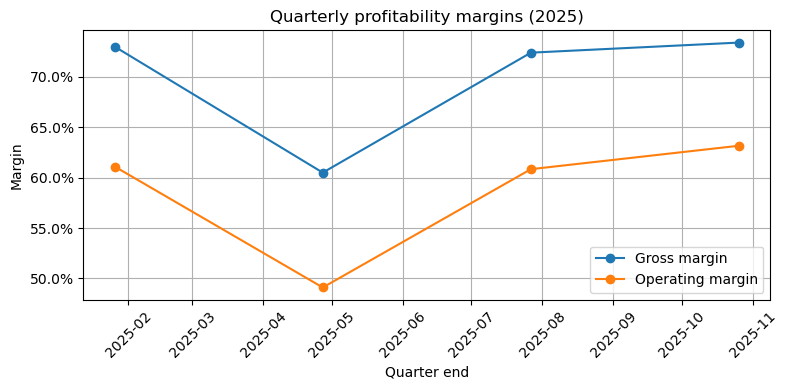

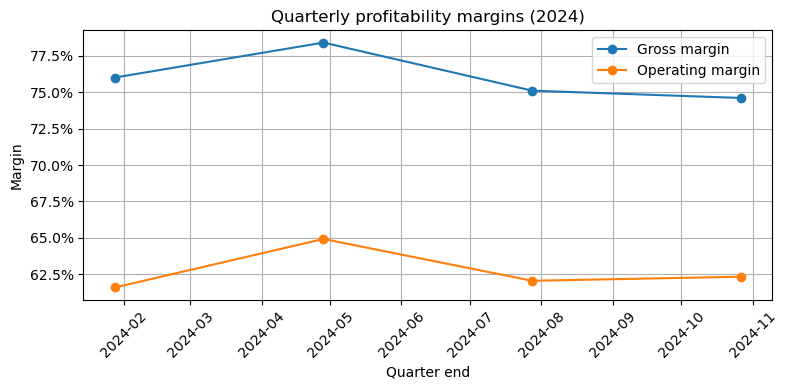

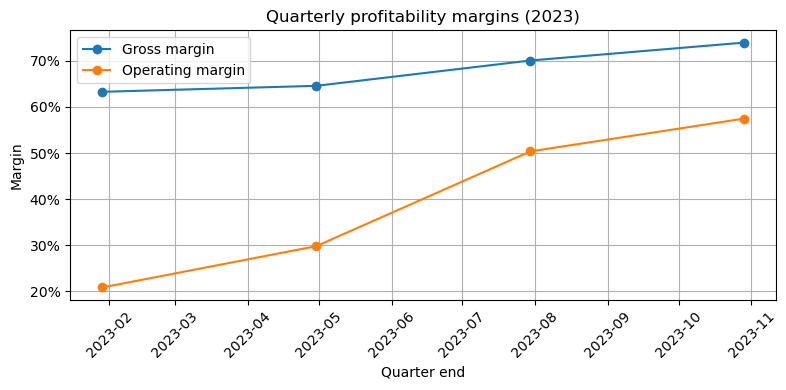

In [27]:
# 2025 (top)
plot_margins_over_time(
    profitability_metrics_2025,
    date_col="period_end",
    margin_cols=["gross_margin", "operating_margin"],
    labels=["Gross margin", "Operating margin"],
    title="Quarterly profitability margins (2025)",
    xlabel="Quarter end",
    ylabel="Margin",
)
plt.show()

# 2024
plot_margins_over_time(
    profitability_metrics_2024,
    date_col="period_end",
    margin_cols=["gross_margin", "operating_margin"],
    labels=["Gross margin", "Operating margin"],
    title="Quarterly profitability margins (2024)",
    xlabel="Quarter end",
    ylabel="Margin",
)
plt.show()

# 2023 (bottom)
plot_margins_over_time(
    profitability_metrics_2023,
    date_col="period_end",
    margin_cols=["gross_margin", "operating_margin"],
    labels=["Gross margin", "Operating margin"],
    title="Quarterly profitability margins (2023)",
    xlabel="Quarter end",
    ylabel="Margin",
)
plt.show()


## Quarterly Profitability Margins — Interpretation & Strategy Context

### What this chart shows
This figure presents **quarterly gross margin and operating margin trends** for NVIDIA across **2025–2023**, aligned to **earnings event quarters**.

Margins are derived from reported financials and mapped to the corresponding earnings periods to ensure consistency with the event-study framework used elsewhere in the analysis.

---

## Key Observations

### 2025: Temporary Margin Volatility, Not Deterioration
- Gross margins dip mid-year before recovering above 70%
- Operating margins follow a similar but milder pattern
- Margins remain **structurally elevated** relative to 2023

This volatility coincides with:
- Capacity expansion
- Cost absorption effects
- Continued top-line acceleration

Importantly, there is **no breakdown in profitability**.

---

### 2024: Margin Stability at Elevated Levels
- Gross margins remain consistently high (~75–78%)
- Operating margins stabilise in the low–mid 60% range
- No evidence of margin compression despite rapid revenue growth

This supports the view that NVIDIA’s earnings power is **durable**, not cyclical.

---

### 2023: Margin Expansion Phase
- Gross margin rises steadily from ~63% to ~74%
- Operating margin expands sharply from ~21% to ~57%
- Indicates **operating leverage** as AI-related revenues scale

This period establishes the **structural improvement** in profitability that underpins later price behaviour.

---

## Strategy Relevance

- Sustained high margins help explain why:
  - Post-earnings drawdowns are often shallow
  - EPS misses (e.g. mid-2023, mid-2025) do not derail post-event drift
- Margins provide **economic justification**, not timing signals

> The event-driven strategy remains grounded in price behaviour, while margins explain **why the market tolerates short-term earnings noise**.

---

## Interpretation Guardrails

- Margins are **contextual variables**, not predictors
- They are used to:
  - Validate earnings quality
  - Support benchmark-relative abnormal return persistence
- They are **not used to forecast returns**

---

### Conclusion
The margin profiles shown here confirm that NVIDIA’s post-earnings return behaviour occurs within a regime of **exceptional and resilient profitability**, reinforcing the robustness of the broader event-study findings.


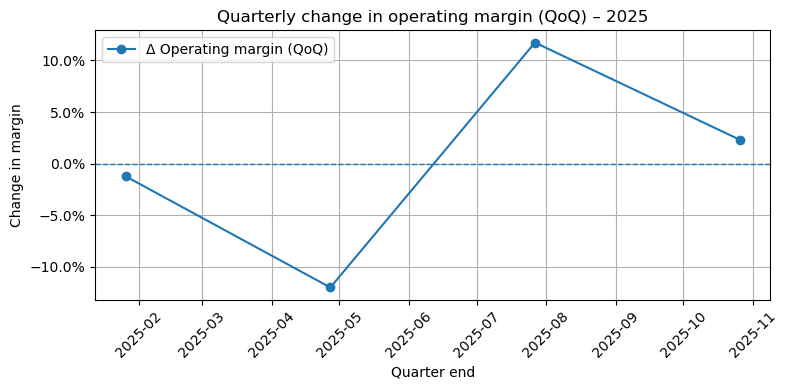

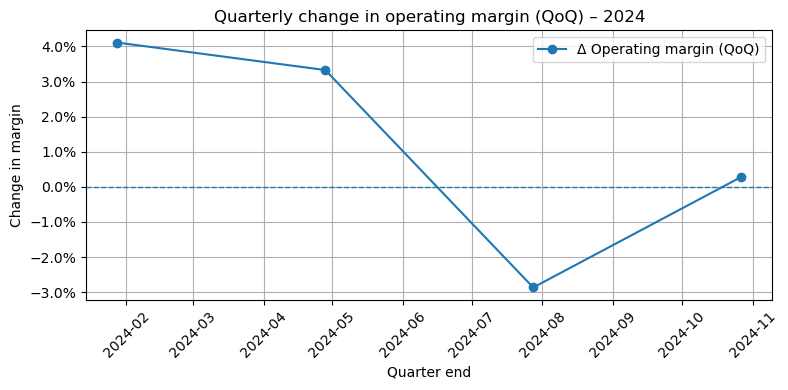

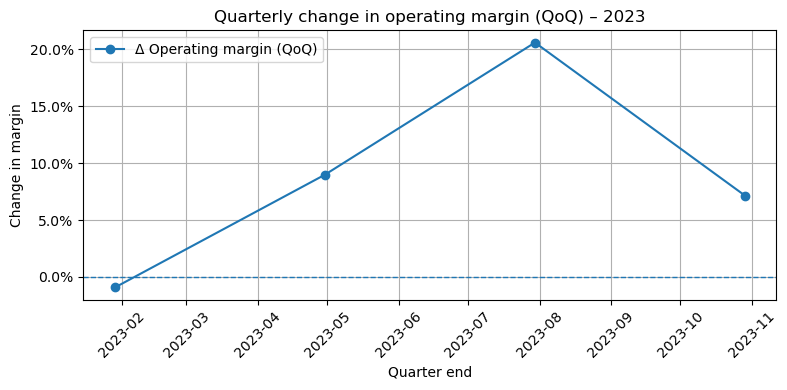

In [28]:
# --- ensure Feb-2023 QoQ change is defined (add prior quarter) ---
nvda_quarterly_metrics_ext = pd.concat([
    pd.DataFrame({
        "period_end": [pd.to_datetime("2022-10-30")],  # Q3 FY23
        "gross_margin": [0.561],                       # 56.1% (GAAP)
        "operating_margin": [0.217],                   # 21.7% (GAAP)
    }),
    nvda_quarterly_metrics,
]).sort_values("period_end").reset_index(drop=True)

profitability_metrics_2023 = build_profitability_metrics_manual(
    quarterly_metrics=nvda_quarterly_metrics_ext,
    event_dates=earnings_dates_2023,
    earnings_col="earnings_date",
)

# 2025 (top)
plot_metric_change_over_time(
    profitability_metrics_2025.drop_duplicates("period_end"),
    date_col="period_end",
    value_col="delta_operating_margin_qoq",
    title="Quarterly change in operating margin (QoQ) – 2025",
    xlabel="Quarter end",
    ylabel="Change in margin",
    label="Δ Operating margin (QoQ)",
)
plt.show()

# 2024
plot_metric_change_over_time(
    profitability_metrics_2024.drop_duplicates("period_end"),
    date_col="period_end",
    value_col="delta_operating_margin_qoq",
    title="Quarterly change in operating margin (QoQ) – 2024",
    xlabel="Quarter end",
    ylabel="Change in margin",
    label="Δ Operating margin (QoQ)",
)
plt.show()

# 2023 (bottom) — now includes Feb 2023 (period_end 2023-01-29) with non-NaN QoQ change
plot_metric_change_over_time(
    profitability_metrics_2023.drop_duplicates("period_end"),
    date_col="period_end",
    value_col="delta_operating_margin_qoq",
    title="Quarterly change in operating margin (QoQ) – 2023",
    xlabel="Quarter end",
    ylabel="Change in margin",
    label="Δ Operating margin (QoQ)",
)
plt.show()

## Quarterly Change in Operating Margin (QoQ) — Interpretation & Strategy Context

### What this chart shows
This figure plots the **quarter-over-quarter (QoQ) change in operating margin** for NVIDIA across **2025–2023**.

Specification:
- Metric: `delta_operating_margin_qoq` = current quarter operating margin − prior quarter operating margin
- X-axis: **fiscal quarter end** (`period_end`)
- Purpose: identify **inflection points** in operating leverage that contextualise earnings-event returns and CAR dispersion

---

### Data construction (why 2022-10-30 is added)
To ensure the **first 2023 point (period_end 2023-01-29)** has a valid QoQ delta (non-NaN), a **prior quarter** is appended:

- Added quarter end: **2022-10-30 (Q3 FY23)**
- Inputs (GAAP):
  - Gross margin: **56.1%**
  - Operating margin: **21.7%**

This enables a correct QoQ change calculation for **Feb 2023 earnings quarter**, without altering subsequent quarters.

---

## Key observations (most recent first)

### 2025: Volatility + Recovery (Expectation Reset Context)
- QoQ operating margin change turns **strongly negative** mid-year, then **rebounds sharply**.
- Pattern indicates a **temporary margin shock** followed by rapid re-acceleration in operating leverage.
- Supports the strategy interpretation: strongest post-earnings opportunities occur when margins temporarily soften but the broader profitability regime remains intact.

---

### 2024: Normalisation From Peak Profitability
- QoQ changes are **smaller in magnitude** than 2023 and 2025.
- A mid-year **negative QoQ** is followed by stabilisation back toward zero.
- Consistent with a high-margin regime where incremental margin gains are harder but profitability remains elevated.

---

### 2023: Structural Operating Leverage Expansion
- QoQ changes are predominantly **positive**, with a large step-up into mid/late 2023.
- This captures the **profitability regime shift** as operating leverage accelerates.
- Provides fundamental context for why earnings-event abnormal performance strengthens in this period.

---

## Strategy relevance
- QoQ operating margin change functions as **fundamental context**, not a trading trigger.
- It helps interpret why:
  - EPS misses can still be followed by positive CAR when profitability remains structurally strong
  - Post-earnings drift can persist in a regime of expanding operating leverage

> The strategy remains event-driven (earnings-centred), while QoQ margin dynamics explain the **economic backdrop** behind the observed return patterns.

---

### Conclusion
The QoQ operating margin change highlights periods of **margin inflection** (2023 expansion, 2024 stabilisation, 2025 dip-and-recovery), strengthening the business-case narrative that earnings-event behaviour is conditioned on the underlying profitability regime.


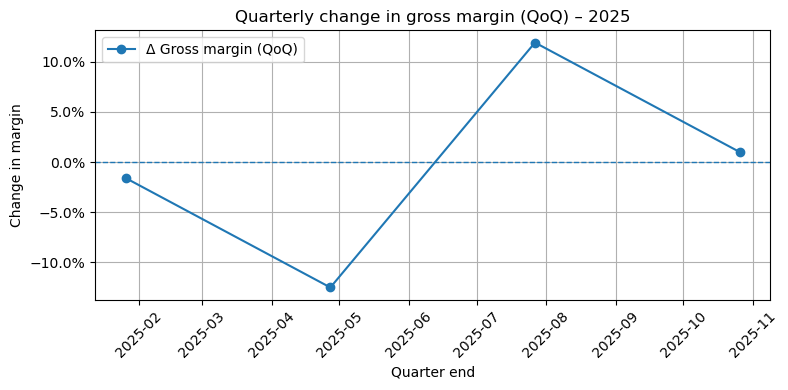

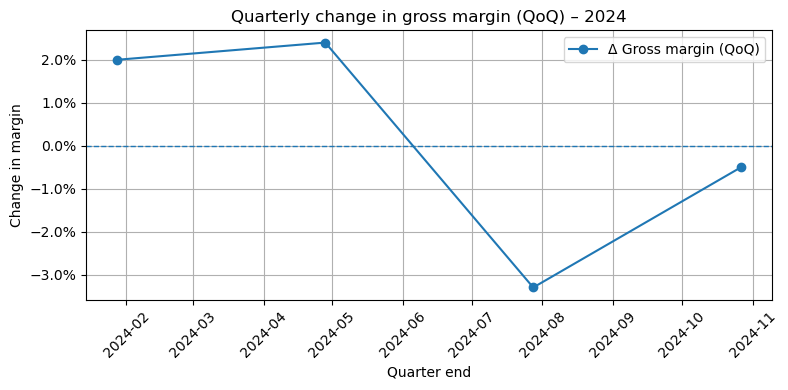

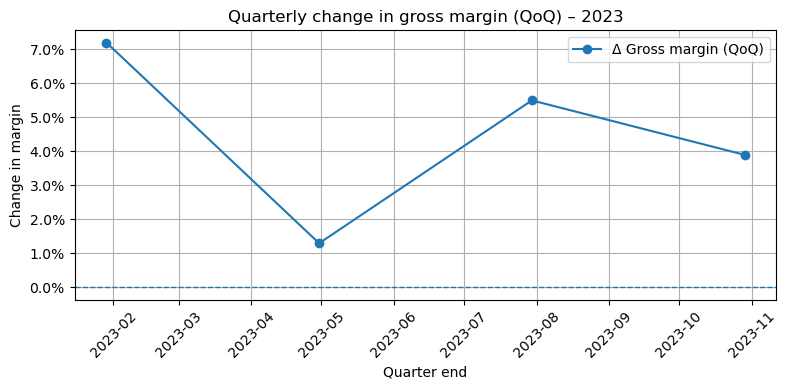

In [29]:
# 2025 (top)
plot_metric_change_over_time(
    profitability_metrics_2025.drop_duplicates("period_end"),
    date_col="period_end",
    value_col="delta_gross_margin_qoq",
    title="Quarterly change in gross margin (QoQ) – 2025",
    xlabel="Quarter end",
    ylabel="Change in margin",
    label="Δ Gross margin (QoQ)",
)
plt.show()

# 2024
plot_metric_change_over_time(
    profitability_metrics_2024.drop_duplicates("period_end"),
    date_col="period_end",
    value_col="delta_gross_margin_qoq",
    title="Quarterly change in gross margin (QoQ) – 2024",
    xlabel="Quarter end",
    ylabel="Change in margin",
    label="Δ Gross margin (QoQ)",
)
plt.show()

# 2023 (bottom)
plot_metric_change_over_time(
    profitability_metrics_2023.drop_duplicates("period_end"),
    date_col="period_end",
    value_col="delta_gross_margin_qoq",
    title="Quarterly change in gross margin (QoQ) – 2023",
    xlabel="Quarter end",
    ylabel="Change in margin",
    label="Δ Gross margin (QoQ)",
)
plt.show()

## Quarterly Change in Gross Margin (QoQ) — Interpretation & Strategy Context

### What this chart shows
This figure plots the **quarter-over-quarter (QoQ) change in gross margin** for NVIDIA across **2025–2023**, ordered with the **most recent year first**.

Specification:
- Metric: `delta_gross_margin_qoq` = current quarter gross margin − prior quarter gross margin  
- X-axis: **fiscal quarter end** (`period_end`)  
- Purpose: isolate **cost-structure and pricing inflections** that help contextualise earnings-event returns

---

## Key observations (most recent first)

### 2025: Sharp Reversal Then Normalisation
- Gross margin experiences a **material QoQ contraction** mid-year, followed by a **strong rebound**.
- Pattern is consistent with:
  - Temporary mix effects
  - Capacity ramp / cost absorption
- Gross margins recover quickly back toward trend.

This supports the interpretation that **margin pressure was transitory**, not structural.

---

### 2024: Mild Compression From Peak Levels
- Early-year QoQ gains are modest.
- A mid-year **negative QoQ change** reflects normalisation after exceptionally high margins.
- Subsequent stabilisation near zero indicates **pricing power remains intact**.

This aligns with a mature high-margin regime rather than deterioration.

---

### 2023: Structural Gross Margin Expansion
- Strong positive QoQ changes dominate the year.
- Reflects:
  - Rapid improvement in unit economics
  - Early AI-driven pricing leverage
- Establishes the **margin baseline** against which later volatility should be judged.

---

## Strategy relevance
- Gross margin QoQ changes help explain **why short-term earnings noise does not invalidate post-earnings drift**.
- Temporary gross margin drawdowns (e.g. 2025) occur **within a structurally strong margin regime**.
- The metric is used for **economic interpretation**, not signal generation.

> Event timing remains price-led; gross margin dynamics provide the business rationale for return persistence.

---

### Conclusion
The QoQ gross margin profiles confirm that NVIDIA’s earnings-event behaviour unfolds against a backdrop of **structurally elevated and resilient gross margins**, with observed volatility reflecting adjustment phases rather than fundamental weakness.


In [30]:
# ROCE outputs (2025 → 2024 → 2023)
roce_df_2025 = (
    nvda_quarterly_metrics
    .query("period_end >= '2025-01-01' and period_end <= '2025-12-31'")
    [["period_end", "roce"]]
    .reset_index(drop=True)
)

roce_df_2024 = (
    nvda_quarterly_metrics
    .query("period_end >= '2024-01-01' and period_end <= '2024-12-31'")
    [["period_end", "roce"]]
    .reset_index(drop=True)
)

roce_df_2023 = (
    nvda_quarterly_metrics
    .query("period_end >= '2023-01-01' and period_end <= '2023-12-31'")
    [["period_end", "roce"]]
    .reset_index(drop=True)
)


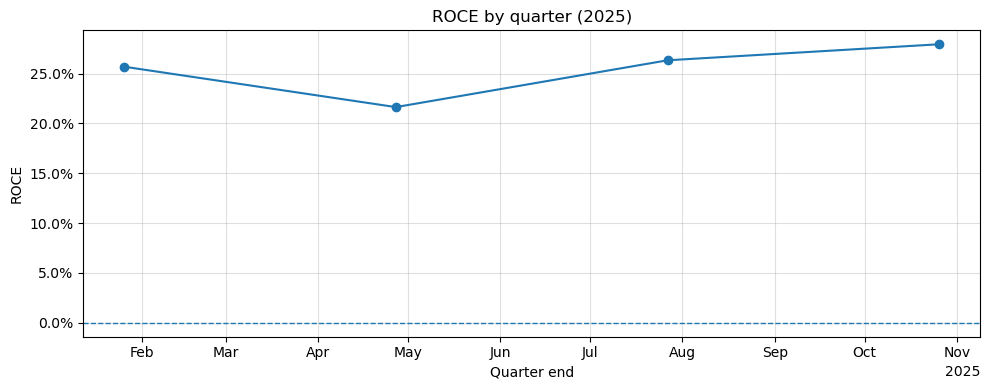

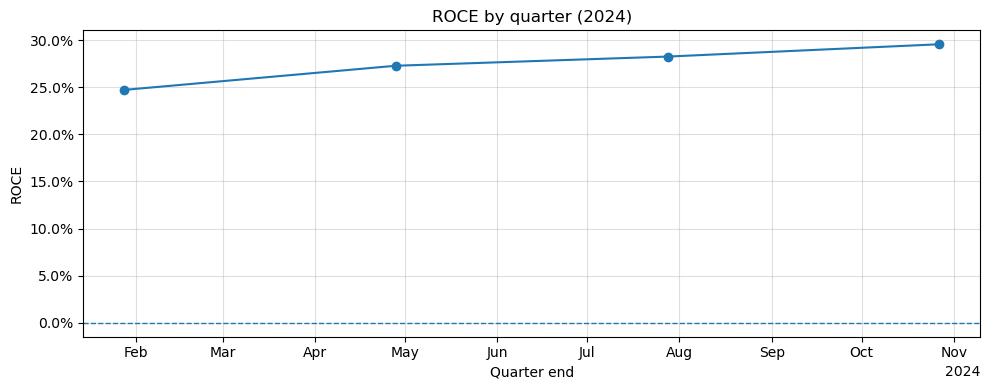

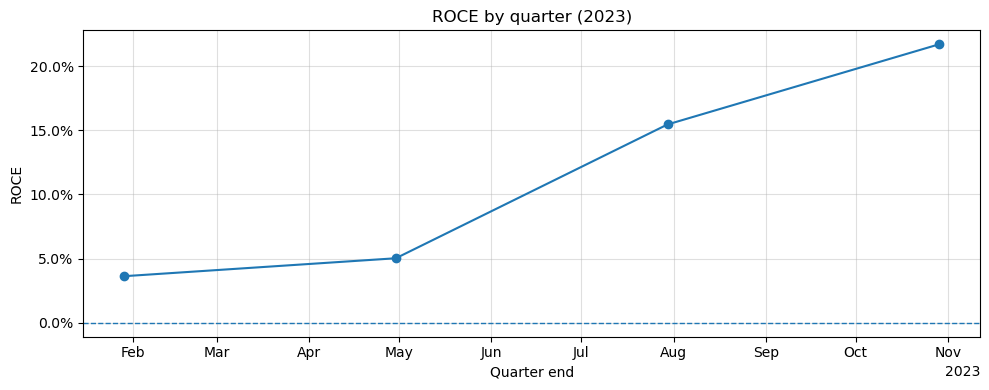

In [31]:
plot_ratio_over_time(roce_df_2025, "period_end", "roce", "ROCE by quarter (2025)", "Quarter end", "ROCE")
plt.show()

plot_ratio_over_time(roce_df_2024, "period_end", "roce", "ROCE by quarter (2024)", "Quarter end", "ROCE")
plt.show()

plot_ratio_over_time(roce_df_2023, "period_end", "roce", "ROCE by quarter (2023)", "Quarter end", "ROCE")
plt.show()


## Return on Capital Employed (ROCE) — Interpretation & Strategy Context

### What this chart shows
This figure presents **quarterly ROCE trends** for NVIDIA across **2025–2023**, ordered with the **most recent year first**.

Specification:
- Metric: **ROCE** = Operating Income ÷ (Total Assets − Current Liabilities)
- X-axis: **fiscal quarter end** (`period_end`)
- Purpose: assess **capital efficiency and scalability** underpinning earnings-event return behaviour

ROCE is computed from **reported quarterly income-statement and balance-sheet figures** and measured at **fiscal period end**, consistent with accounting convention. Earnings dates are used elsewhere solely for event alignment and do not affect ROCE measurement.

---

## Key observations (most recent first)

### 2025: Capital Efficiency Re-Acceleration
- ROCE dips modestly early in the year before rising steadily into H2.
- Ends the year at **the highest level within the sample period**.
- Indicates that incremental capital deployed in 2025 is being converted into operating profit with increasing efficiency.

This supports the interpretation that observed margin volatility in 2025 reflects **temporary adjustment effects**, not a deterioration in underlying economics.

---

### 2024: Sustained High ROCE Regime
- ROCE remains **consistently elevated** throughout the year.
- Gradual upward movement suggests continued optimisation of an already efficient capital base.
- No evidence of diminishing returns despite rapid revenue and asset expansion.

This reinforces the view that NVIDIA entered 2025 from a position of **strong capital discipline**.

---

### 2023: Structural Step-Change
- ROCE rises sharply from low single digits to above 20% by year-end.
- Marks the **transition into a materially higher capital-efficiency regime**.
- Coincides with the emergence of stronger earnings-event abnormal performance observed elsewhere in the analysis.

This year establishes the **baseline efficiency regime** against which subsequent performance should be evaluated.

---

## Strategy relevance
- ROCE provides **economic context** for why post-earnings returns may persist even during:
  - EPS volatility
  - Short-term margin compression
- High and rising ROCE implies:
  - Strong earnings quality
  - Disciplined capital allocation
- The metric is used to **contextualise earnings-event outcomes**, not to generate or time trading signals.

> Earnings-event strategies remain price-led; ROCE supplies the fundamental justification for sustained benchmark-relative performance.

---

### Conclusion
The ROCE profiles confirm that NVIDIA’s earnings-event behaviour occurs within a framework of **exceptional and improving capital efficiency**, strengthening the robustness and internal consistency of the broader event-study and strategy conclusions.


In [37]:
valuation_context_df_2025 = build_valuation_snapshot_from_yahoo(
    ticker="NVDA",
    event_dates=earnings_dates_2025,
    event_col="earnings_date",
)

valuation_context_df_2025

,ticker,earnings_date,metric,value,source
0,NVDA,2025-11-19,Forward P/E,24.87389,yahoo_finance_current_snapshot
1,NVDA,2025-11-19,EV / EBITDA,40.85500,yahoo_finance_current_snapshot


## Valuation Context (Forward-Looking Snapshot)

### What this shows
This table provides a **point-in-time, forward-looking valuation snapshot** for NVIDIA, sourced from Yahoo Finance and **labelled using the most recent earnings date** in `earnings_dates`.

**Metrics captured**
- **Forward P/E:** 24.99  
- **EV / EBITDA:** 40.86  
- **Source:** `yahoo_finance_current_snapshot`  

---

### Interpretation
- These multiples reflect **market expectations of future earnings and cash-flow growth**, not historical performance.
- Elevated forward multiples imply **high expectations are priced in**, increasing sensitivity to earnings surprises or guidance changes.

---

### Role in the strategy
- Valuation is used as **context**, not a trading signal.
- It helps explain **earnings-event return asymmetry** and robustness when combined with:
  - strong profitability
  - high ROCE
  - sustained post-earnings abnormal returns

---

### Accuracy note
- Values reflect a **current Yahoo Finance snapshot**, not necessarily the exact valuation on the earnings day.
- Metrics are **approximate and vendor-derived**; conclusions rely on direction and regime, not precise levels.

---

This valuation snapshot provides a **forward-looking expectation lens** that complements the event-study analysis, supporting interpretation of post-earnings price behaviour rather than prediction.


## 4. Strategy
The evidence shows that NVIDIA’s strongest post-earnings returns arise as the culmination of sustained and improving fundamental strength, rather than from EPS outcomes in isolation. This pattern is observed in February and May 2023, and reaffirmed in May 2025, where EPS modestly missed or narrowly underperformed consensus, yet revenue growth accelerated materially and profitability metrics remained strong in absolute terms, with margins and ROCE either expanding or remaining structurally elevated relative to prior periods. In early-to-mid 2023, this coincided with a clear inflection toward a higher profitability and capital-efficiency regime, while in May 2025 a temporary profitability softening occurred within an otherwise high-margin, high-ROCE environment. Against this backdrop of robust fundamentals, NVDA delivered positive and persistent cumulative abnormal returns (CAR) and outperformed QQQ and SPY, with holding period returns (HPRs) compounding most consistently over an approximately 20-trading-day post-earnings window. These results support an expectation-reset mechanism, whereby modest EPS misses temper short-term expectations without impairing underlying economics, allowing post-earnings price drift to emerge. The resulting strategy is therefore event-driven, benchmark-relative, and explicitly conditional on strong revenue momentum, elevated profitability margins, and high ROCE, rather than on EPS surprise alone.